# Detecting item misfit in Rasch models

Magnus Johansson [](https://orcid.org/0000-0003-1669-592X) (RISE Research Institutes of Sweden, Division Built Environment, System Transition, Centre for Psychiatry Research, Department of Clinical Neuroscience, Karolinska Institutet, & Stockholm Health Care Services, Region Stockholm)  
January 4, 2025

Psychometrics in general have long relied on rule-of-thumb critical values for various goodness of fit metrics. With more powerful personal computers it is both feasible and desirable to use simulation methods to determine appropriate critical cutoff values. This paper illustrates and evaluates the use of an R package for Rasch psychometrics that has implemented functions to simplify the process of determining simulation based cutoff values. Through a series of simulation studies a comparison is made between information weighted conditional item fit (“infit”) and item-restscore correlations using Goodman and Kruskal’s $\gamma$. Results indicate the limitations of small samples (n \< 500) in correctly detecting item misfit, especially when several items are misfit. Item outfit shows very low performance and should not be used. Conditional infit with simulation based cutoffs performs slightly better than item-restscore with samples below n = 500. Both methods have strongly increased rates of false positives with large samples (n \>= 1000). Large samples should use non-parametric bootstrap of subsamples with item-restscore to avoid type-1 errors. Finally, the importance of iterative analyses is emphasized since a situation where several items show underfit will induce seemingly overfit items. Underfit item should be removed one at a time, and a re-analysis conducted for each step to avoid erroneously removing items.

# Introduction

This paper presents a series of simulations conducted to evaluate methods to detect of item misfit in Rasch models. First, conditional item infit and outfit will be under scrutiny. Second, item infit will be compared to item-restscore \[@kreiner_note_2011;@mueller_iarm_2022\]. Third, a bootstrap method for item-restscore will be presented and tested.

The assessment of item fit under the Rasch model has for decades been conducted using various rule-of-thumb critical values. Müller \[-@muller_item_2020\] showed how the range of critical values for conditional item infit varies with sample size. The expected average item conditional infit range was described by Müller as fairly well captured by Smith’s rule-of-thumb formula 1±2/√n \[@smith_using_1998\]. However, the average range does not apply for all items, since item location relative to sample location also affects model expected item fit. This means that some items within a set of items varying in location are likely to have item fit values outside Smith’s average value range while still fitting the Rasch model.

It is here proposed that by using parametric bootstrapping one can establish item fit critical cutoff values that are sample and item specific. This procedure uses the estimated item and person locations based on the available data and simulates new response data that fit the Rasch model, to determine the range of plausible item fit values for each item. The R package `easyRasch` \[@easyrasch\] includes a function to determine item infit and outfit cutoff values using this method and will be tested in the simulations in this paper.

It is important to note that the conditional item fit described by Müller \[-@muller_item_2020\] and implemented in the `iarm` R package \[@mueller_iarm_2022\] should not be confused with the unconditional item fit implemented in software such as Winsteps and RUMM2030, as well as all R packages except `iarm`. Unconditional item fit can result in unreliable item fit in sample sizes as small as 250 with increasing likelihood of problems as sample size increases. Readers are strongly recommended to read Müller’s paper to fully understand the issues with unconditional item fit.

# Methods

In [ ]:
library(iarm)

Loading required package: eRm

Loading required package: ggplot2

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: formattable
Loading required package: kableExtra

Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

Loading required package: mirt
Loading required package: stats4
Loading required package: lattice

Attaching package: 'mirt'

The following objects are masked from 'package:eRm':

    itemfit, personfit

Loading required package: psych

Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

The following object is masked from 'package:eRm':

    sim.rasch

Loading required package: psychotree
Loading required package: partykit
Loading required package: grid
Loading required package: libcoin
Loading required package: mvtnorm
Loading required package: psychotools
Loading required package: matrixStats

Attaching package: 'matrixStats'

The following object is masked from 'package:dplyr':

    count

Loading required package: reshape

Attaching package: 'reshape'

The

Some features are not enabled in this build of Arrow. Run `arrow_info()` for more information.
The repository you retrieved Arrow from did not include all of Arrow's features.
You can install a fully-featured version by running:
`install.packages('arrow', repos = 'https://apache.r-universe.dev')`.

Attaching package: 'arrow'

The following object is masked from 'package:lubridate':

    duration

The following object is masked from 'package:utils':

    timestamp

Loading required package: sysfonts
Loading required package: showtextdb

A fully reproducible manuscript with R code and data is available on GitHub: <https://github.com/pgmj/rasch_itemfit>

The simulation of response data used three steps: First, a vector of theta values (person scores on the latent variable’s logit scale) were generated using `rnorm(mean = 0, sd = 1.5)`. Second, a set of item locations ranging from -2 to 2 logits were generated for dichotomous items, using `runif(n = 20, min = -2, max = 2)`. Third, the theta values were used to simulate item responses for participants, using `sim.xdim()` from the `eRm` package \[@mair_extended_2007\], which allows simulation of multidimensional response data. Multiple datasets with 10 000 respondents each were generated using the same item and person parameters, varying the targeting of the misfitting item(s) and number of the misfitting item(s). More details are described under the separate studies. The parametric bootstrapping procedure was implemented using random samples from the simulated datasets. Sample size variations tested are described under each study.

The general procedure for the parametric bootstrapping is as follows:

1.  Estimation of item locations based on simulated item response data, using conditional maximum likelihood \[CML, @mair_extended_2007\].
2.  Estimation of sample theta values using weighted maximum likelihood \[@warm_weighted_1989\].
3.  Simulation of new response data which fit the Rasch model, using the estimated item locations and theta values.
4.  Estimation of the dichotomous Rasch model for the new response data using CML.
5.  Based on step 4, calculation of conditional item infit and outfit \[@muller_item_2020;@mueller_iarm_2022\] and/or item-restscore metrics \[@kreiner_note_2011;@mueller_iarm_2022\].

Steps three and four were iterated over, using resampling with replacement from the estimated theta values as a basis for simulating the response data in step three.

Summary statistics were created with focus on the percentage of correct detection of misfit and false positives.

A complete list of software used for the analyses is listed in #sec-addmat.

In [ ]:
# read pre-generated item locations for reproducibility
items1 <- read_csv("data/rm_items40.csv") %>%
  slice(1:20) %>% 
  pull(location)

Rows: 40 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): item, location

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
# a matrix to specify which dimension each item loads on
wmat0 <- matrix(nrow = 20,
               ncol = 2)
# set all items to load on dimension one
wmat0[1:20,1] <- 1
wmat0[1:20,2] <- 0
# item 9, with good targeting in this item set (closest to sample theta mean of 0), is chosen to belong to a second dimension
wmat0[9,1] <- 0
wmat0[9,2] <- 1

# a matrix to specify which dimension each item loads on
wmat1 <- matrix(nrow = 20,
               ncol = 2)
wmat1[1:20,1] <- 1
wmat1[1:20,2] <- 0
wmat1[18,1] <- 0
wmat1[18,2] <- 1

# a matrix to specify which dimension each item loads on
wmat2 <- matrix(nrow = 20,
               ncol = 2)
wmat2[1:20,1] <- 1
wmat2[1:20,2] <- 0
wmat2[13,1] <- 0
wmat2[13,2] <- 1

# generate dichotomous data
simdata0 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat0)
simdata1 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat1)
simdata2 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat2)

simdata <- list(data0 = simdata0,
                data1 = simdata1,
                data2 = simdata2)
#saveRDS(simdata,"simdata10000.rds")

### And one dataset with all 3 items misfitting
# a matrix to specify which dimension each item loads on
wmat3 <- matrix(nrow = 20,
               ncol = 2)
# set all items to load on dimension one
wmat3[1:20,1] <- 1
wmat3[1:20,2] <- 0
# item 9, with good targeting in this item set (closest to sample theta mean of 0), is chosen to belong to a second dimension
wmat3[c(9,13,18),1] <- 0
wmat3[c(9,13,18),2] <- 1

# generate dichotomous data
simdata3 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat3)

saveRDS(simdata3,"data/simdata3.rds")

In [ ]:
simdata <- readRDS("data/simdata10000.rds")
simdata3 <- readRDS("data/simdata3.rds") %>% 
  as.data.frame()
demodata <- simdata[[1]] %>% 
  as.data.frame() %>% 
  slice(1:400) %>% 
  select(V1,V11,V3,V12)

# Study 1: Item infit and outfit

Item mean square standardized residuals are either unweighted, which is referred to as “outfit”, or information weighted, which we call “infit” \[@ostini_polytomous_2006, pp. 86-87\]. For details on conditional item fit we refer to the previously mentioned paper by Müller \[-@muller_item_2020\]. Conditional item infit and outfit are expected to be near 1, with higher values indicating an item to be underfitting the Rasch model (often due to multidimensionality issues) and lower values indicating overfit.

The function `RIgetfit()` from the `easyRasch` R package is tested here. It’s source code can be accessed on GitHub, see #sec-addmat. The function offers the user a choice of the number of bootstrap iterations to use to determine the critical cutoff values for each item’s infit and outfit. Our main interest in this study is two-fold. We want to test variations in the number of iterations used in `RIgetfit()` and evaluate how well the critical values based on the parametric bootstrapping procedure detects misfitting items. Additionally, a comparison between infit and outfit statistics in terms of detection rate and false positive rate will be conducted.

20 dichotomous items are used, with one item misfitting. Item locations are the same throughout all studies unless otherwise noted. The location of the misfitting item relative the to the sample theta mean was selected to be approximately 0, -1, and -2 logits. Three separate datasets were generated with these variations, each with 10 000 simulated respondents. One dataset with all three misfitting items was also generated, using the same sample size.

Then the `RIitemfit()` function is used to summarize the bootstrap results and also calculates the infit and outfit for each item in the observed data and highlights items with infit/outfit values outside of the cutoff values. `RIitemfit()` has a default (user modifiable) setting to slightly truncate the distribution of values using `stats::quantile()` at 0.001 and 0.999 to remove extreme values. An example is demonstrated in @tbl-itemfit1, using a subset of the items used in the simulations. @fig-itemfit1 provides a visualization of the distribution of bootstrapped infit and outfit values, together with the infit/outfit values from the observed data illustrated using an orange diamond shape. Note the variation between items in plausible values of infit and outfit based on the bootstrap, and that Smith’s rule-of-thumb regarding infit (1±2/√n) would be 0.9-1.1 for a sample size of 400.

This study was rather computationally demanding since each simulation run entailed 100-400 underlying bootstrap iterations. The sample sizes used were 150, 250, 500, and 1000. The number of iterations to determine cutoff values were 100, 200, and 400. Sample size and iteration conditions were fully crossed with each other and the three different targeting variations of the one misfitting item, resulting in 4*3*3 = 36 conditions. Each combination used 200 simulation runs. The simulations took about 12 hours to run on a Macbook Pro Max M1 using 9 CPU cores.

In [ ]:
simfit <- RIgetfit(demodata, iterations = 400, cpu = 8)
RIitemfit(demodata, simfit, output = "quarto")

  ----------------------------------------------------------------------------------------
  Item     InfitMSQ Infit           OutfitMSQ Outfit         Infit    Outfit      Location
                    thresholds                thresholds     diff     diff      
  ------ ---------- ------------- ----------- -------------- -------- --------- ----------
  V1          1.017 \[0.869,            1.061 \[0.657,       no       no misfit      -1.37
                    1.172\]                   1.74\]         misfit             

  V11         1.000 \[0.826,            1.032 \[0.729,       no       no misfit      -0.66
                    1.18\]                    1.353\]        misfit             

  V3          1.022 \[0.91,             1.050 \[0.703,       no       no misfit       0.46
                    1.103\]                   1.483\]        misfit             

  V12         0.966 \[0.858,            0.793 \[0.766,       no       no misfit       1.58
                    1.201\]                   1.293\]        misfit             
  ----------------------------------------------------------------------------------------


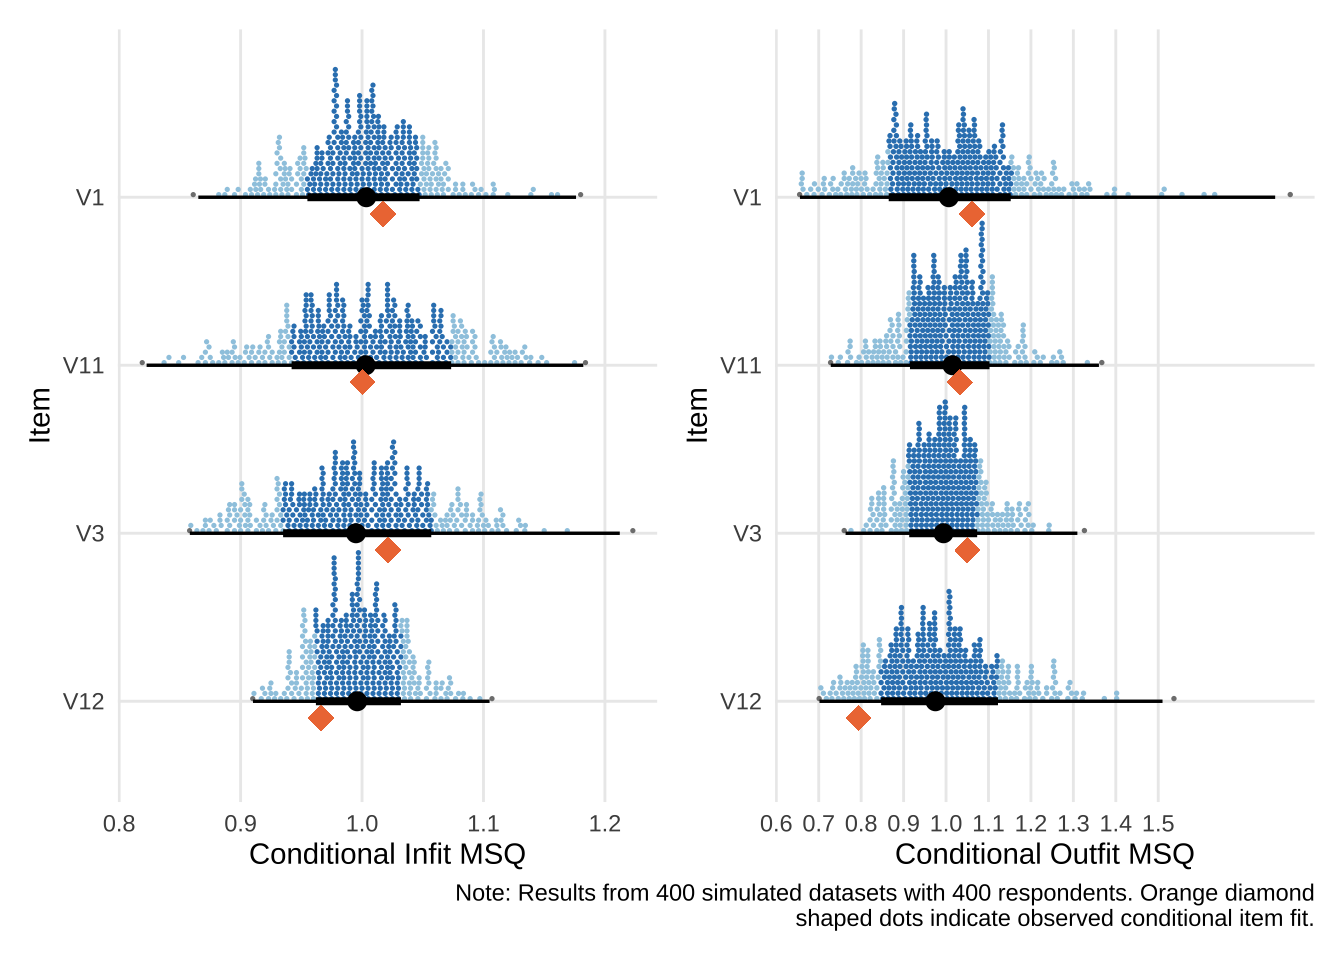

In [ ]:
RIgetfitPlot(simfit, demodata)

In [ ]:
# define function to run simulations for item infit/outfit cutoff values
itemfitboot <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    # get simulation based cutoff values
    sfit100 <- RIgetfit(data,100,9)
    sfit200 <- RIgetfit(data,200,9)
    sfit400 <- RIgetfit(data,400,9)

    # apply cutoffs and store results
    rfit100 <- RIitemfit(data,sfit100, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 100,
                 iteration = i,
                 samplesize = samplesize)
    
    rfit200 <- RIitemfit(data,sfit200, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 200,
                 iteration = i,
                 samplesize = samplesize)
    
    rfit400 <- RIitemfit(data,sfit400, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 400,
                 iteration = i,
                 samplesize = samplesize)
    
    # combine output 
    fit <- rbind(rfit100,rfit200,rfit400)
  }
  return(fit)
}

In [ ]:
samplesizes <- c(150,250,500,1000)

ifb0 <- list()
ifb1 <- list()
ifb2 <- list()

#library(tictoc)
#tic()
ifb0 <- map(samplesizes, ~ itemfitboot(simdata[[1]], iterations = 200, samplesize = .x))
#toc() # 14257.358 sec elapsed

ifb1 <- map(samplesizes, ~ itemfitboot(simdata[[2]], iterations = 200, samplesize = .x))
ifb2 <- map(samplesizes, ~ itemfitboot(simdata[[3]], iterations = 200, samplesize = .x))

# saveRDS(ifb0, "data/ifb0_200.rds")
# saveRDS(ifb2, "data/ifb2_200.rds")
# saveRDS(ifb1, "data/ifb1_200.rds")

ifb0_df <- map_dfr(1:4, ~ do.call("rbind", ifb0[[.x]])) %>% 
  add_column(targeting = 0)

ifb1_df <- map_dfr(1:4, ~ do.call("rbind", ifb1[[.x]])) %>% 
  add_column(targeting = 1)

ifb2_df <- map_dfr(1:4, ~ do.call("rbind", ifb2[[.x]])) %>% 
  add_column(targeting = 2)

ifb <- rbind(ifb0_df,ifb1_df,ifb2_df)

write_parquet(ifb,"data/ifb.parquet")

## Results

In [ ]:
ifb <- read_parquet("data/ifb.parquet")

Figures show the percent of simulation runs that have identified an item as misfitting. Items with more than 5% are colored in light red. A number representing the detection rate is shown adjacent to the bar representing the misfitting item. The figure grid columns are labelled with the number of iterations used by `RIgetfit()` to determine cutoff values, and grid rows are labelled with the sample size.

### Infit

(`geom_col()`).

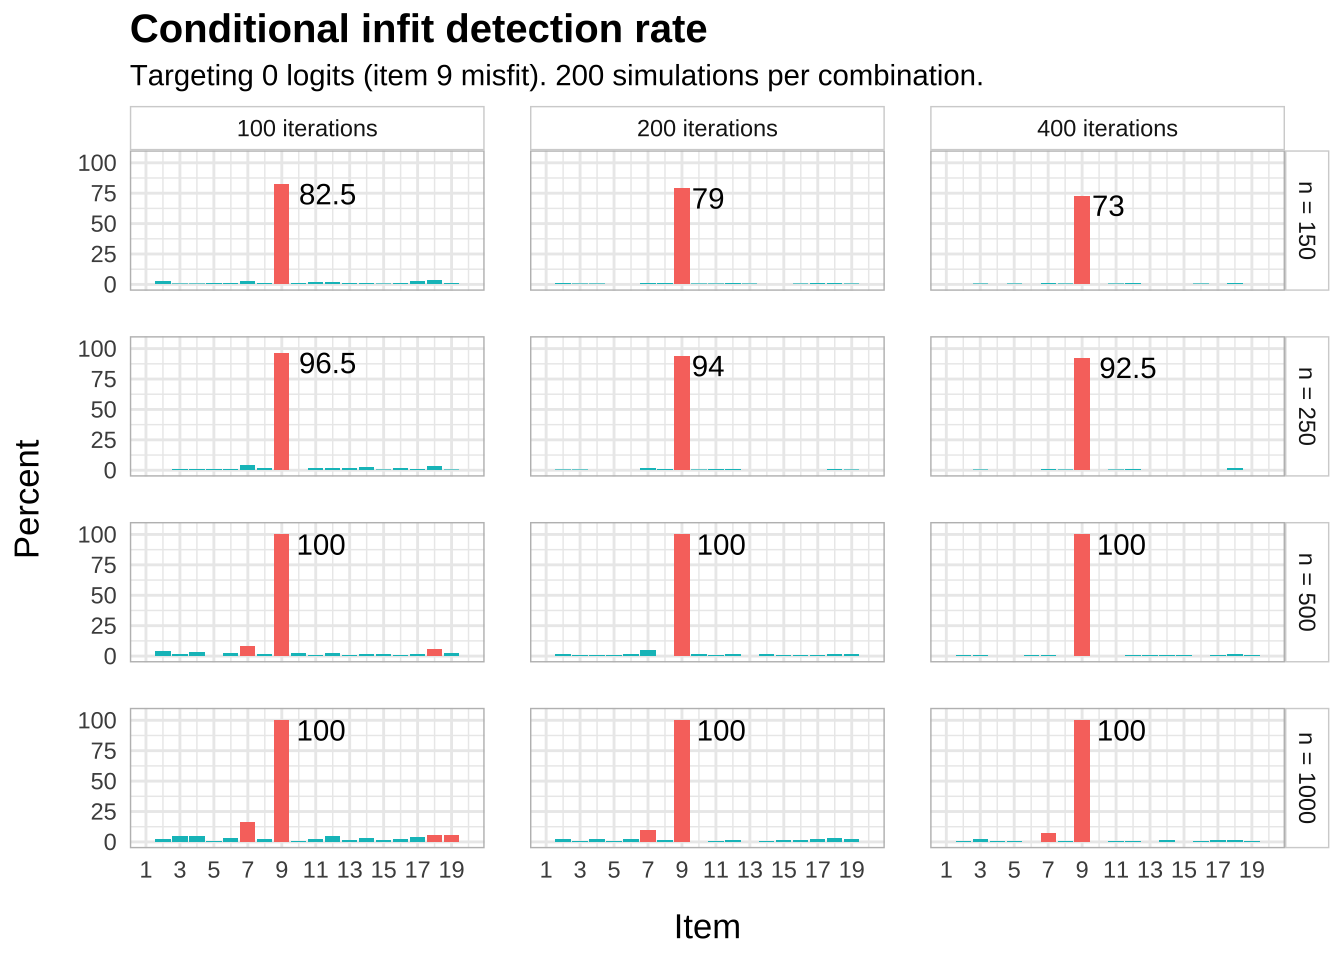

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 0) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000"))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting 0 logits (item 9 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

@fig-ifb0 shows the detection rate when the misfitting item is located at the sample mean. Detection rate is highest for the condition with 100 iterations with sample size 100 and 250, but it also shows higher levels of false positives when sample size increases to 500 or more.

(`geom_col()`).

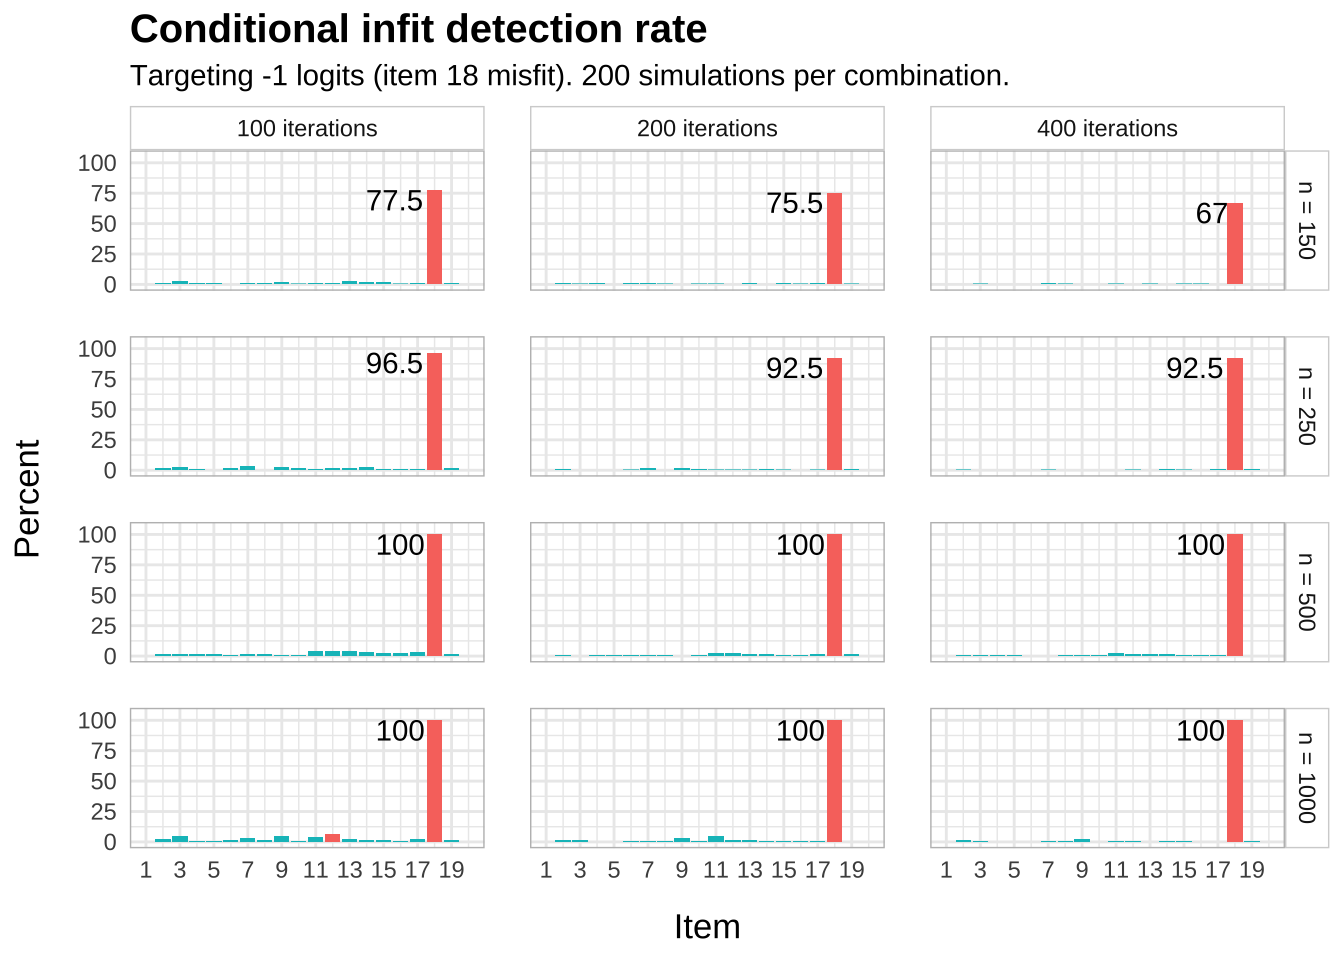

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 1) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000"))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -1 logits (item 18 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

When the misfitting item is offset in targeting by -1 logits compared to the sample mean (see @fig-ifb1), the smallest sample size has less power to detect misfit compared to the on-target misfitting item. There are lower rates of false positives across all sample sizes and iterations.

(`geom_col()`).

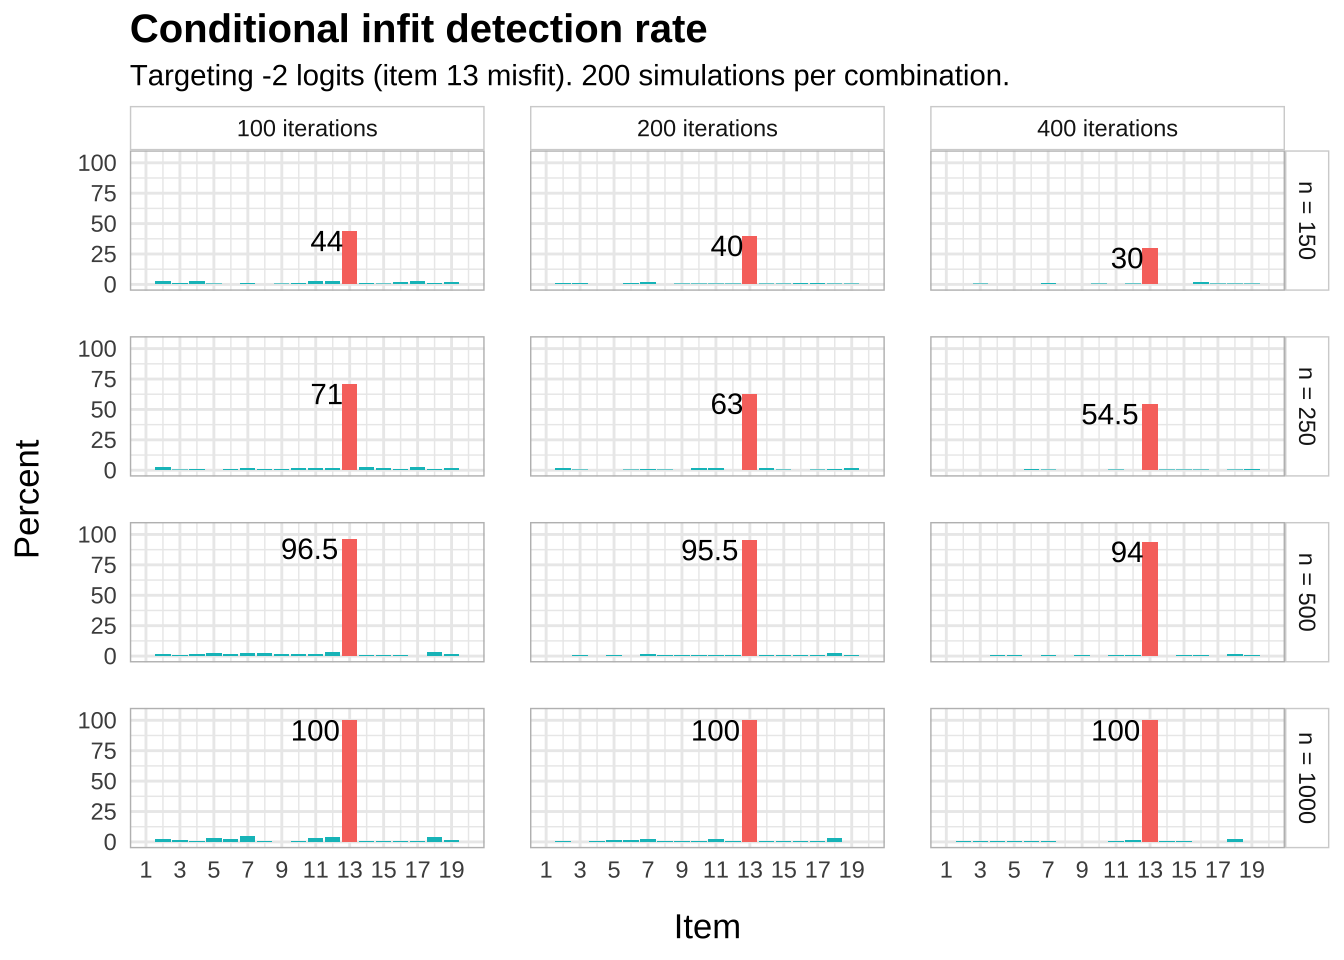

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 2) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000"))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -2 logits (item 13 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

Finally, when the misfitting item is located at -2 logits compared to the sample mean (see @fig-ifb2), we see a stronger reduction in power for sample sizes 150 and 250. No false positives are identified.

### Outfit

(`geom_col()`).

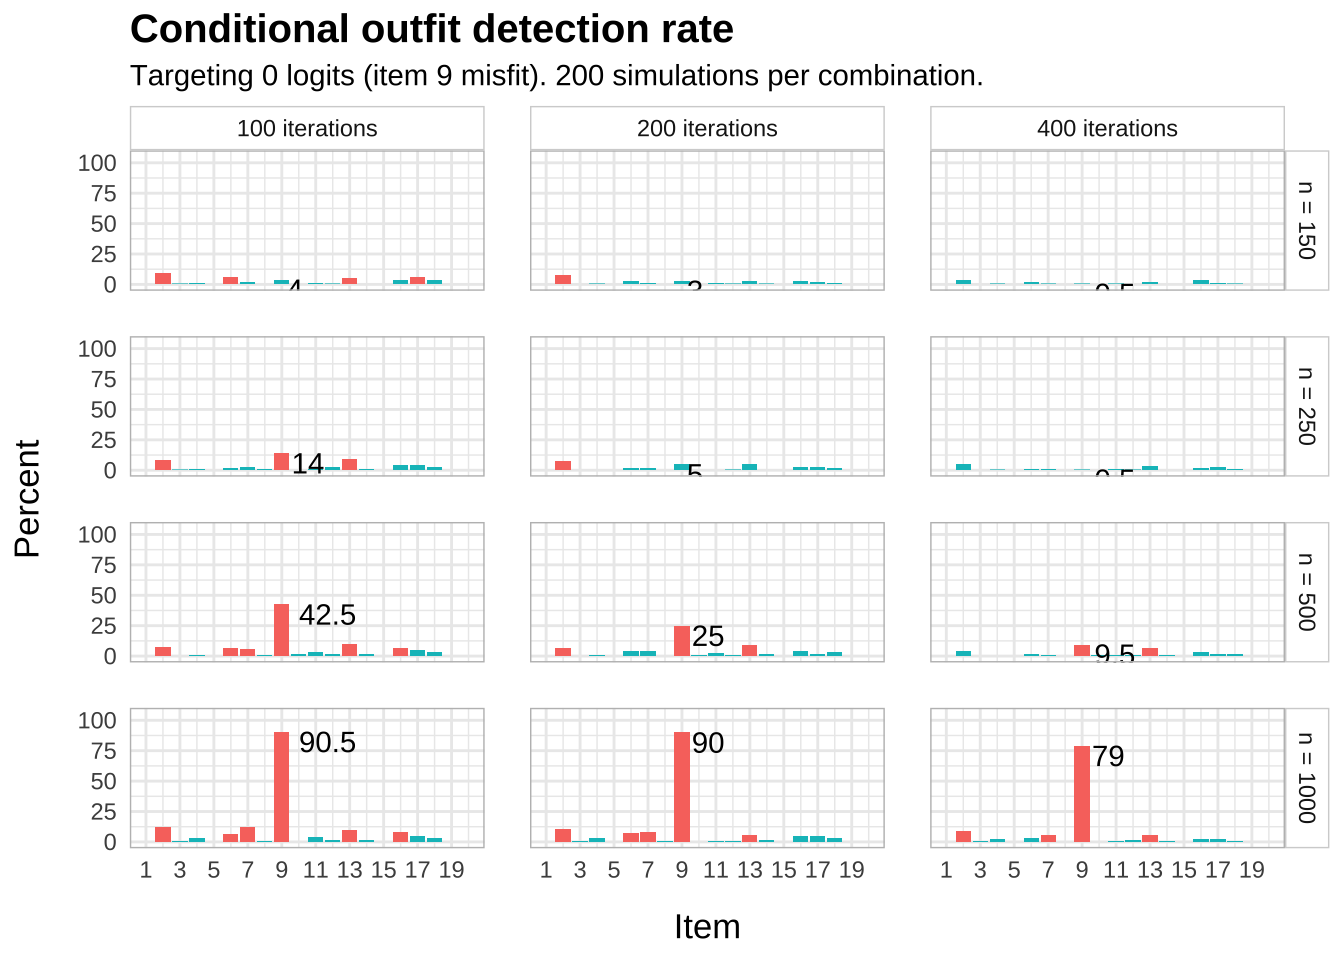

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 0) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
    ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000"))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting 0 logits (item 9 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

(`geom_col()`).

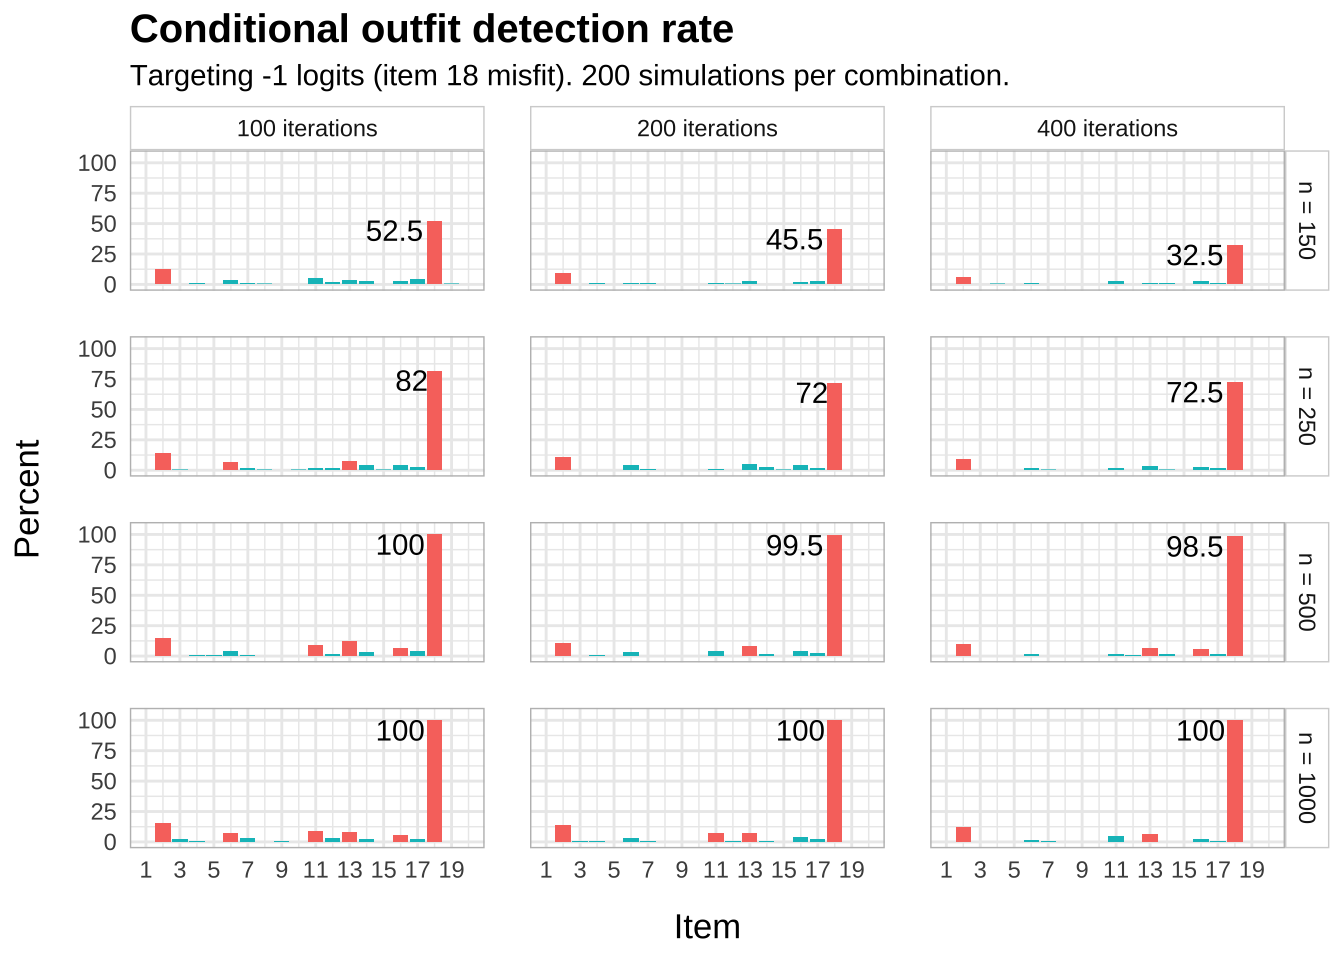

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 1) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
    ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000"))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -1 logits (item 18 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

(`geom_col()`).

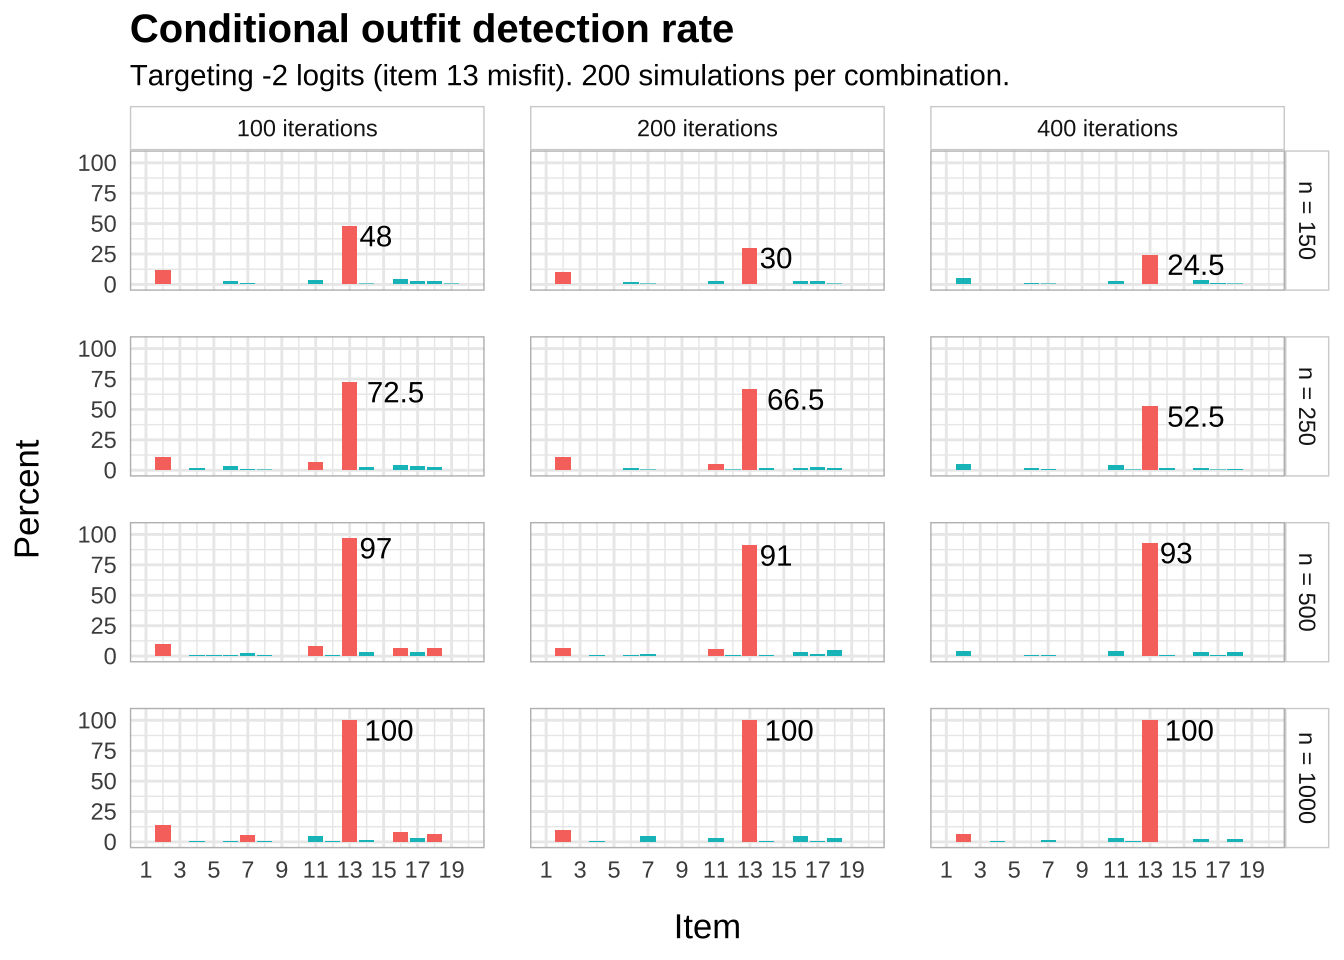

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 2) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
    ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000"))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -2 logits (item 13 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

As shown in @fig-ifb0out, @fig-ifb1out, and @fig-ifb2out, outfit is performing much worse than infit across the board.

### Comments

Based on these simulation, it seems reasonable to recommend the use of infit in determining item fit over outfit. The performance of outfit calls to question whether it is useful at all.

Regarding infit and the use of parametric bootstrapping with `RIgetfit()`, it looks like 100 iterations are to recommend to determine cutoff values when the sample size is 250 or lower, while 200 or 400 iterations reduce the risk for false positives at sample sizes of 500 or larger. False positives are found at sample sizes 500 and 1000 only. The risk for false positives is notably higher when the misfitting item is located at the sample mean compared to when the misfitting item is off-target by -1 logits or more.

# Study 2: Item-restscore

Item-restscore is a metric that compares an expected correlation with the observed correlation, using Goodman and Kruskal’s $\gamma$ \[@goodman_measures_1954;@kreiner_note_2011\]. Lower observed values than expected indicates than an item is underfit to the Rasch model, while higher values indicate overfit. The item-restscore function used in this simulation is from the `iarm` package \[@mueller_iarm_2022\] and outputs Benjamini-Hochberg corrected *p*-values \[@benjamini_controlling_1995\], which are used to determine whether the differences between the observed and expected values are statistically significant (using *p* \< .05 as critical value) for each item.

In [ ]:
ir <- function(dat, iterations, samplesize, cpu = 9) {
  
  require(doParallel)
  registerDoParallel(cores = cpu)
  
  fit <- data.frame()
  fit <- foreach(i = 1:iterations, .combine = rbind) %dopar% {
    data <- dat[sample(1:nrow(dat), samplesize), ]
    
    erm_out <- RM(data)
    
    cfit <- out_infit(erm_out)
    cfit_d <- data.frame(infit = cfit$Infit, outfit = cfit$Outfit) %>% 
      round(3)
    
    i1 <- item_restscore(erm_out)
    i1 <- as.data.frame(i1)
    
    i1d <- data.frame("observed" = as.numeric(i1[[1]][1:ncol(data),1]),
                     "expected" = as.numeric(i1[[1]][1:ncol(data),2]),
                     "se" = as.numeric(i1[[1]][1:ncol(data),3]),
                     "p.value" = as.numeric(i1[[1]][1:ncol(data),4]),
                     "p.adj.BH" = as.numeric(i1[[1]][1:ncol(data),5])
    ) %>% 
      mutate(diff_abs = abs(expected - observed),
             diff = expected - observed,
             ir_padj = ifelse(p.adj.BH < .05, "sign. misfit","no misfit")) %>% 
      select(ir_padj, diff, diff_abs) %>% 
      mutate(item = 1:ncol(data)) %>% 
      add_column(iteration = i,
                 samplesize = samplesize)
    cbind(i1d,cfit_d)
  }
  return(fit)
}

In [ ]:
samplesizes <- c(100,150,250,500,1000)

ir0 <- list()
ir1 <- list()
ir2 <- list()
#library(tictoc)
#tic()
ir0 <- map(samplesizes, ~ ir(simdata[[1]], iterations = 1000, samplesize = .x))
ir1 <- map(samplesizes, ~ ir(simdata[[2]], iterations = 1000, samplesize = .x))
ir2 <- map(samplesizes, ~ ir(simdata[[3]], iterations = 1000, samplesize = .x))
#toc()
# 483.373 sec elapsed

irall <- list(ir0,ir1,ir2)

#saveRDS(irall,"data/item_restscore1000.rds")

## Results

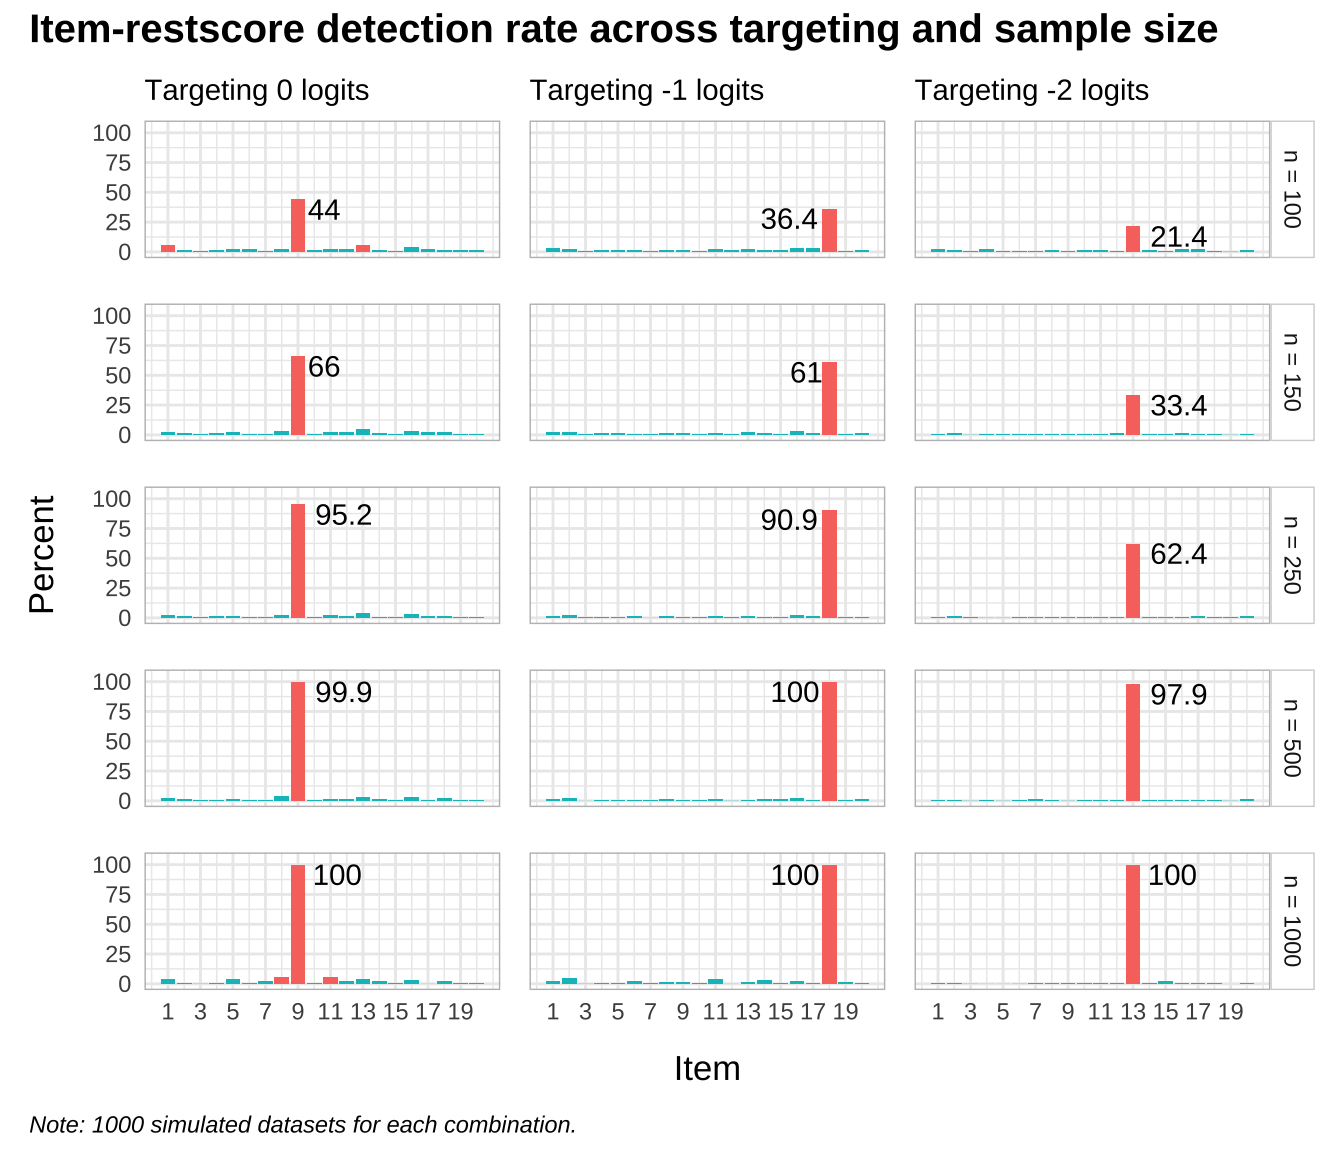

In [ ]:
ir_all <- readRDS("data/item_restscore1000.rds")
ir_results <- bind_rows(ir_all[[1]],ir_all[[2]],ir_all[[3]]) %>% 
  add_column(targeting = rep(c(0,1,2), each = 100000))

# using patchwork and separate plots to get geom_text working across targeting variations
results0 <- ir_results %>% 
  filter(targeting == 0) %>% 
  group_by(targeting, samplesize) %>% 
  filter(ir_padj == "sign. misfit" ) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/1000,
         targeting = factor(targeting, levels = c(0,1,2), labels = c('On target','-1 logit offset','-2 logits offset'))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting 0 logits") +
  theme(strip.text = element_blank())

results1 <- ir_results %>% 
  filter(targeting == 1) %>% 
  group_by(targeting, samplesize) %>% 
  filter(ir_padj == "sign. misfit" ) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/1000,
         targeting = factor(targeting, levels = c(0,1,2), labels = c('On target','1 logit offset','2 logits offset'))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 18),
            aes(label = n/10), position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -1 logits") +
  theme(strip.text = element_blank())

results2 <- ir_results %>% 
  filter(targeting == 2) %>% 
  group_by(targeting, samplesize) %>% 
  filter(ir_padj == "sign. misfit" ) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/1000,
         targeting = factor(targeting, levels = c(0,1,2), labels = c('On target','1 logit offset','2 logits offset'))) %>% 
  mutate(samplesize = factor(samplesize, levels = c(100,150,250,500,1000),
                       labels = c("n = 100",
                                  "n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000"))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 13),
            aes(label = n/10), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -2 logits")

results0 + results1 + results2 +
  plot_layout(axes = "collect",
              axis_titles = "collect") +
  plot_annotation(title = "Item-restscore detection rate across targeting and sample size",
                  caption = "Note: 1000 simulated datasets for each combination.",
                  theme = theme_rise(fontfamily = "sans"))

This simulation includes an additional condition with 100 respondents, which results in significantly lower detection rates than with 150 respondents. Compared to infit at 250 respondents, item-restscore has detection rates of 95.2%, 90.9%, and 62.4% for targeting 0, -1, and -2, while infit has 96.5%, 96.5%, and 71%. For sample size 500 and 1000, performance is similar, including the increased tendency for false positives at n = 1000.

Similarly to infit, item-restscore has decreased detection rate for off-target misfitting items. The false positive rate is lower for item-restscore than infit for sample sizes below 1000.

# Study 3: Comparing infit and item-restscore

We will now compare the performance of infit and item-restscore when all three items are misfitting at the same time. This simulation will also include a condition with 2000 respondents, to examine if the false positive rate increases with more respondents. For infit, we will only use 200 iterations with `RIgetfit()` since that condition seemed to strike a balance between detection rate and false positives.

In [ ]:
# define function to run simulations for item infit/outfit cutoff values
itemfitboot2 <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    sfit200 <- RIgetfit(data,200,9)

    # apply cutoffs and store results
    rfit200 <- RIitemfit(data,sfit200, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 200,
                 iteration = i,
                 samplesize = samplesize)

    
    # combine output 
    fit <- rfit200
  }
  return(fit)
}

In [ ]:
samplesizes <- c(150,250,500,1000,2000)
ifb3 <- list()
ir3 <- list()

ifb3 <- map(samplesizes, ~ itemfitboot2(simdata3, iterations = 500, samplesize = .x))

ir3 <- map(samplesizes, ~ ir(simdata3, iterations = 500, samplesize = .x))

#saveRDS(ifb3,"data/ifb3.rds")
#saveRDS(ir3,"data/ir3.rds")

In [ ]:
ifb3 <- readRDS("data/ifb3.rds")
ir3 <- readRDS("data/ir3.rds")

ifb3_df <- bind_rows(ifb3)
ir3_df <- bind_rows(ir3)

### Results

(`geom_col()`).

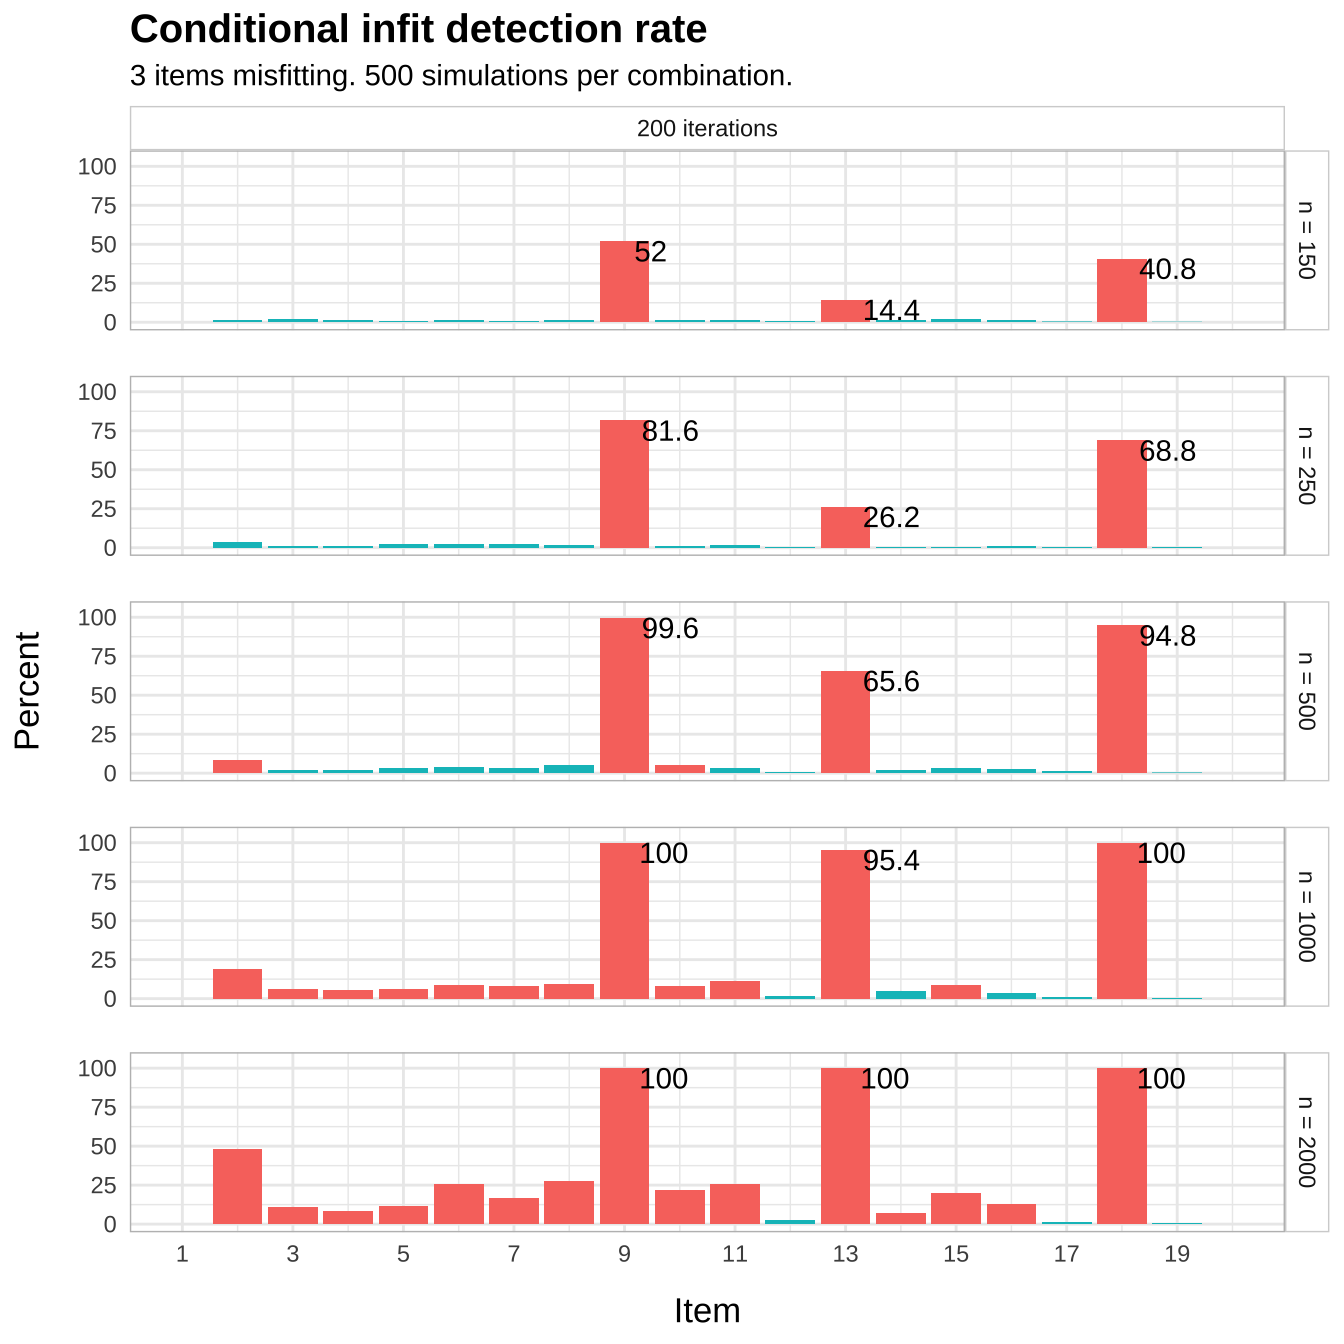

In [ ]:
ifb3_df %>% 
  group_by(samplesize, sims) %>% 
  filter(!infit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/500*100) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000")),
         sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations"))) %>% 

  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 500 simulations per combination.",
       title = "Conditional infit detection rate")

(`geom_col()`).

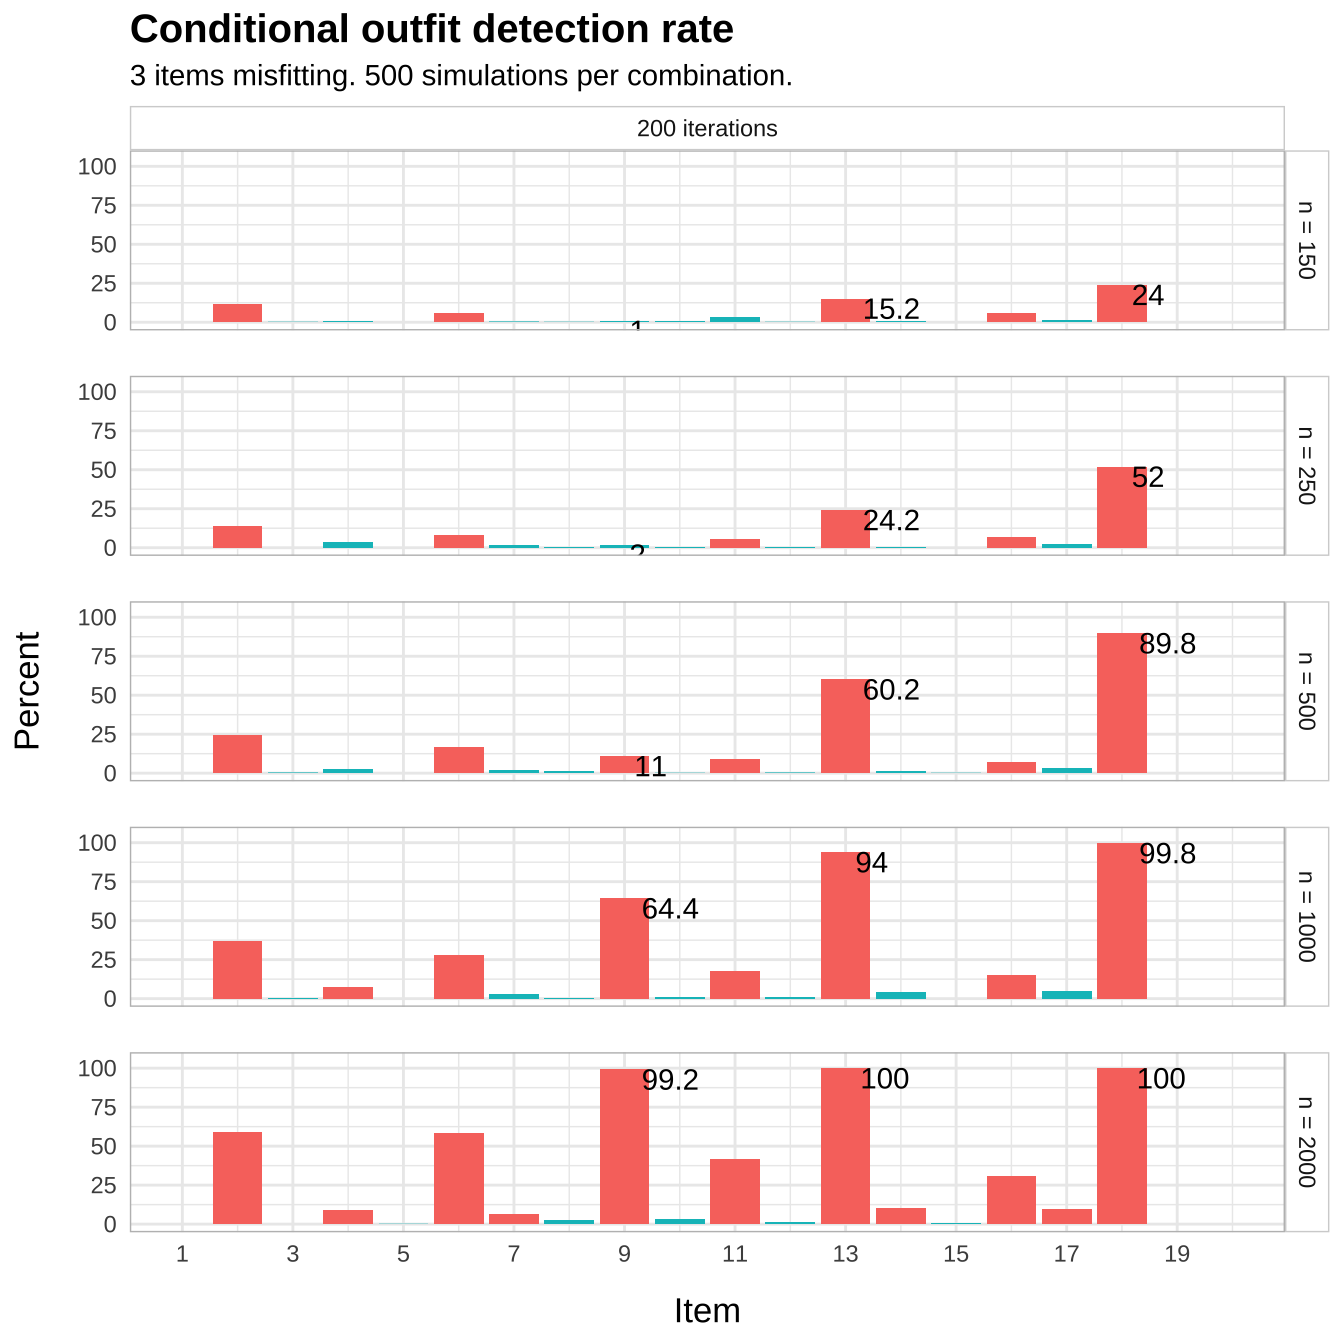

In [ ]:
ifb3_df %>% 
  group_by(samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/500*100) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000")),
         sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations"))) %>% 

  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 500 simulations per combination.",
       title = "Conditional outfit detection rate")

Looking at the performance of infit with three misfitting items (@fig-ifb3), we can see that the detection rate is markedly worse for item 13 (targeting -1 logits) in sample sizes 500 and below, compared to when single items were misfitting. The false positive rate has increased for sample size of 1000 and we can see it escalate when n = 2000. Outfit (@fig-ifb3out) again performs worse than infit.

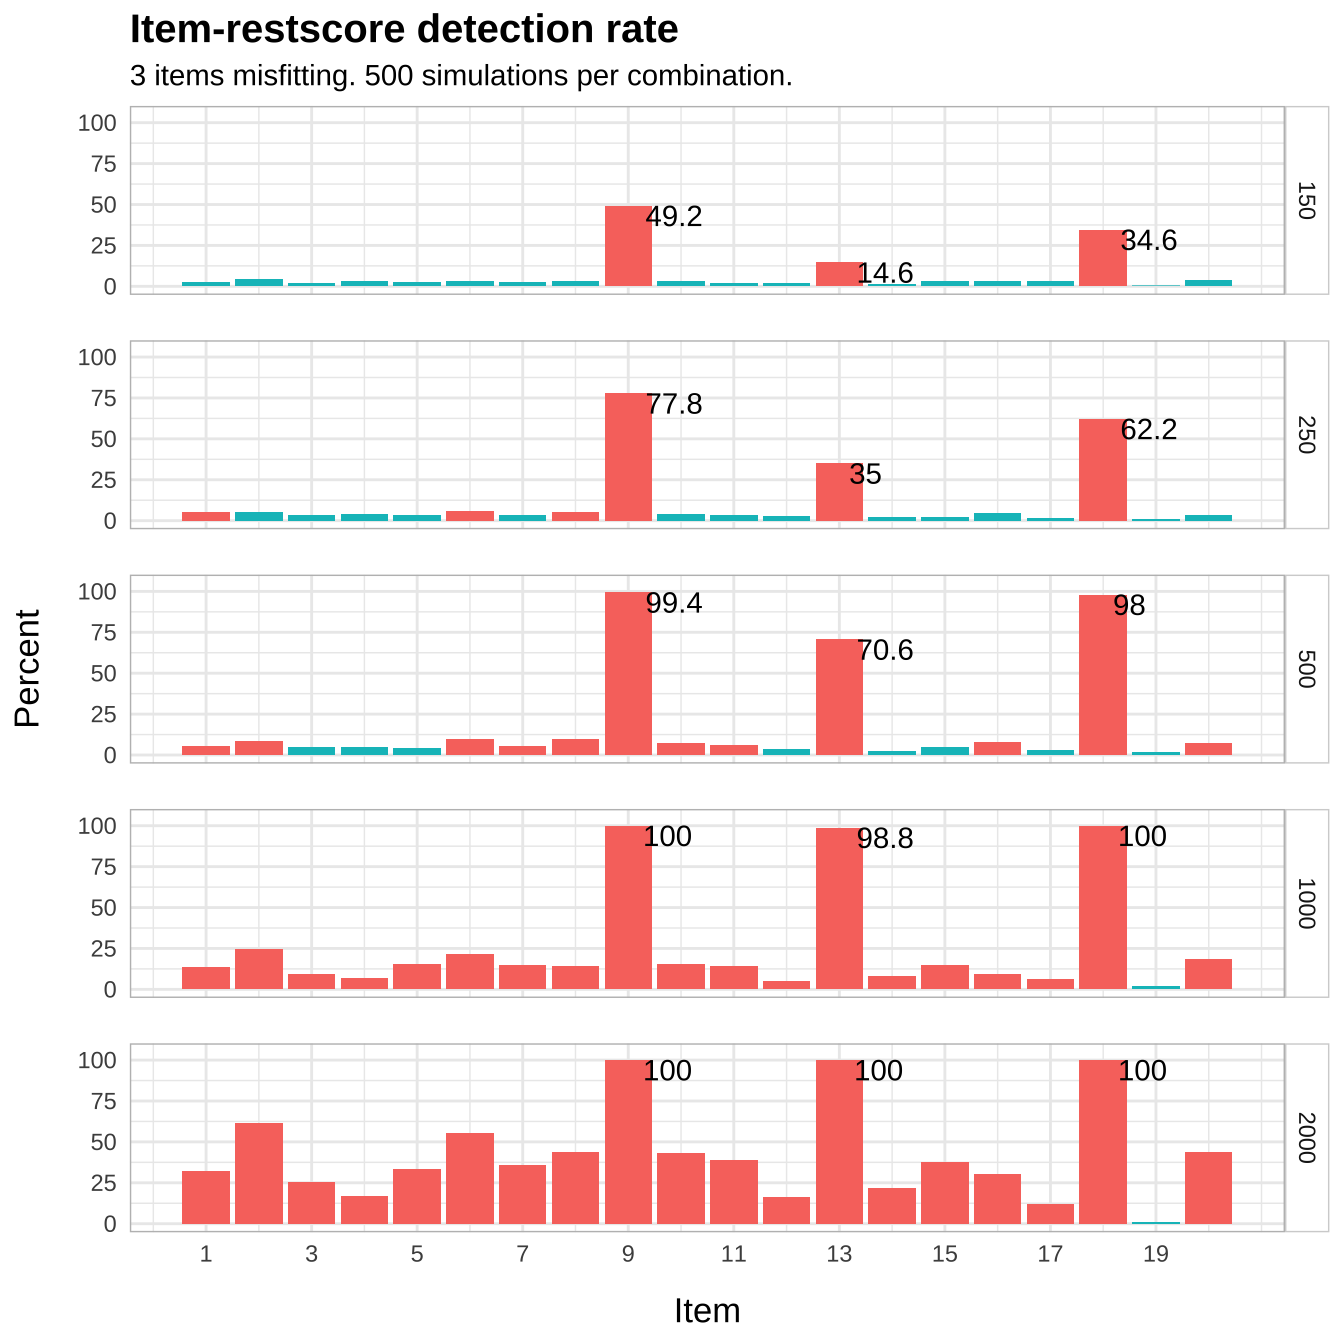

In [ ]:
ir3_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 500 simulations per combination.",
       title = "Item-restscore detection rate")

In [ ]:
ir3_df %>%
  filter(ir_padj == "sign. misfit") %>% 
  mutate(type = ifelse(diff < 0, "overfit","underfit")) %>% 
  count(item,type) %>% 
  set_names(c("Item","Type of misfit","n")) %>% 
  knitr::kable()

    Item Type of misfit        n
  ------ ---------------- ------
       1 overfit             299
       2 overfit             520
       3 overfit             224
       4 overfit             181
       5 overfit             298
       6 overfit             475
       7 overfit             313
       8 overfit             382
       9 underfit           2132
      10 overfit             365
      11 overfit             326
      12 overfit             149
      12 underfit              2
      13 underfit           1595
      14 overfit             182
      15 overfit             313
      16 overfit             278
      17 overfit             129
      18 underfit           1974
      19 overfit              31
      20 overfit             387


Item-restscore has higher detection rate than infit (see @fig-itemrestscore2), but also higher levels of false positives. Reviewing the type of misfit identified by item-restscore (see @tbl-overunder), the false positives are all overfitting the Rasch model, except for two instances indicating underfit for item 12. Items 9, 13, and 18, that were simulated to be misfitting due to loading on a separate dimension, are as expected showing underfit to the Rasch model.

# Study 4: Bootstrapped item-restscore

For our final set of simulations, we will use a non-parametric bootstrap procedure with item-restscore. The difference from the parametric bootstrap is that the non-parametric bootstrap samples with replacement directly from the observed response data. First, based on the above problematic sample size of 2000 when three items are misfitting, we will use the bootstrap function to sample with replacement using n = 800 and 250 bootstrap samples. The function `RIbootRestscore()` from the `easyRasch` package will be used.

In [ ]:
#tic()
simdata3 %>% 
  slice_sample(n = 2000) %>% 
  RIbootRestscore(iterations = 250, samplesize = 800, cpu = 8, output = "dataframe", cutoff = 0) %>% 
  select(item,item_restscore,percent) %>% 
  filter(!item_restscore == "no misfit") %>% 
  arrange(desc(percent)) %>% 
  set_names(c("Item","Item-restscore result","Percent of iterations")) %>% 
  knitr::kable()
#toc()

  Item   Item-restscore result     Percent of iterations
  ------ ----------------------- -----------------------
  V18    underfit                                  100.0
  V9     underfit                                  100.0
  V13    underfit                                   85.6
  V14    overfit                                    42.4
  V6     overfit                                    40.0
  V10    overfit                                    37.2
  V12    overfit                                    25.6
  V16    overfit                                    20.8
  V7     overfit                                    20.4
  V20    overfit                                    20.0
  V2     overfit                                    14.0
  V5     overfit                                    13.6
  V3     overfit                                    10.8
  V8     overfit                                    10.0
  V1     overfit                                     2.8
  V19    overfit                                     2.4
  V4     overfit                                     1.2
  V17    underfit                                    0.8
  V15    overfit                                     0.4
  V15    underfit                                    0.4
  V19    underfit                                    0.4
  V4     underfit                                    0.4


`RIbootRestscore()` is demonstrated using a single sample in @tbl-bootir, where the table is sorted on Percent of iterations. The runtime was around 10-12 seconds using 8 CPU cores on a Macbook Pro M1 Max. In our simulation, we will repeat this procedure 500 times and report the average and standard deviation for the percent indicating misfit for each item.

Second, we will also apply the bootstrapped item-restscore method to sample sizes 150 and 250, using the complete sample for the same bootstrap procedure to see if this produces more useful information than previously tested strategies for identifying misfitting items.

## Results

In [ ]:
ir_boot <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    fit <- RIbootRestscore(data, iterations = 250, samplesize = 800, cpu = 9, output = "dataframe", cutoff = 0) %>% 
      select(item,item_restscore,percent) %>% 
      filter(!item_restscore == "no misfit") %>% 
      add_column(iteration = i)
    
  }
  return(fit)
}

irb0 <- ir_boot(simdata3, 500, 2000)
saveRDS(irb0,"data/irb0.rds")

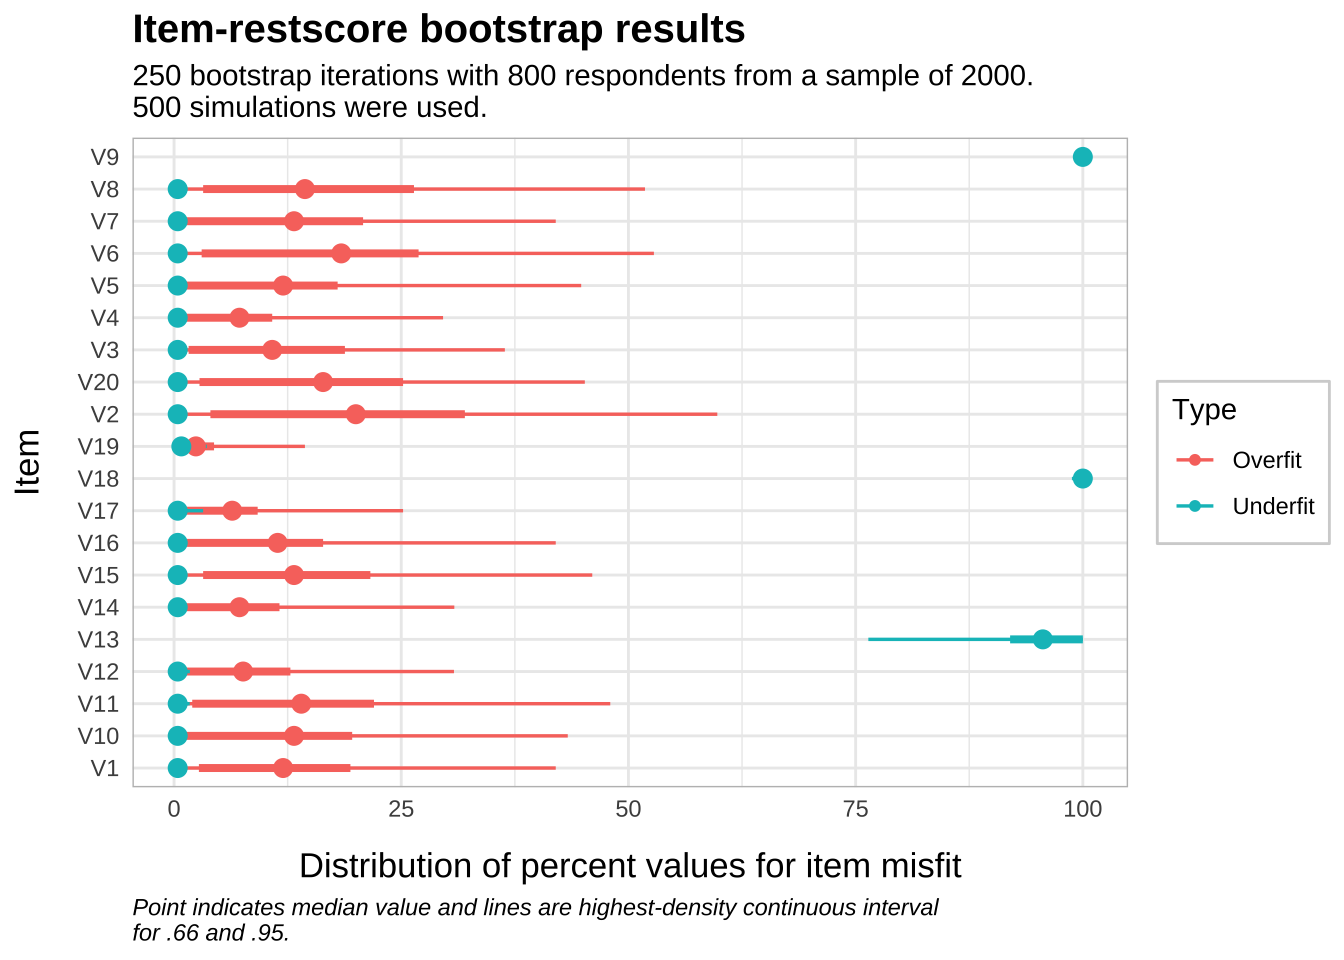

In [ ]:
irb0 <- readRDS("data/irb0.rds")

irb0_df <- bind_rows(irb0)

irb0_df %>% 
  ggplot(aes(x = percent, y = item, color = item_restscore)) +
  stat_pointinterval(point_interval = "median_hdci") +
  theme_rise(fontfamily = "sans") +
  labs(caption = str_wrap("Point indicates median value and lines are highest-density continuous interval for .66 and .95.",80),
       x = "Distribution of percent values for item misfit", y = "Item",
       title = "Item-restscore bootstrap results",
       subtitle = str_wrap("250 bootstrap iterations with 800 respondents from a sample of 2000. 500 simulations were used.",70)
       ) +
  scale_color_discrete('Type', labels = c("Overfit","Underfit"))

``` r
irb0_df %>% 
  filter(item %in% c("V9","V13","V18")) %>% 
  rename(Item = item) %>% 
  group_by(Item) %>% 
  summarise(Median = median(percent),
            MAD = mad(percent),
            Mean = mean(percent),
            SD = sd(percent),
            p05 = quantile(percent, .05),
            p01 = quantile(percent, .01)
            ) %>% 
  ungroup() %>% 
  arrange(desc(p01)) %>% 
  mutate_if(is.numeric, round, 1) %>% 
  knitr::kable()
irb0_df %>% 
  filter(!item %in% c("V9","V13","V18"),
         item_restscore == "overfit") %>% 
  rename(Item = item) %>% 
  group_by(Item) %>% 
  summarise(Median = median(percent),
            MAD = mad(percent),
            Mean = mean(percent),
            SD = sd(percent),
            p95 = quantile(percent, .95),
            p99 = quantile(percent, .99)
            ) %>% 
  ungroup() %>% 
  arrange(desc(p99)) %>% 
  mutate_if(is.numeric, round, 1) %>% 
  knitr::kable()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: center;"><div class="cell-output-display" width="100.0%" data-layout-align="center">
<table id="tbl-irb0mis-1" class="do-not-create-environment">
<thead>
<tr>
<th style="text-align: left;">Item</th>
<th style="text-align: right;">Median</th>
<th style="text-align: right;">MAD</th>
<th style="text-align: right;">Mean</th>
<th style="text-align: right;">SD</th>
<th style="text-align: right;">p05</th>
<th style="text-align: right;">p01</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: left;">V9</td>
<td style="text-align: right;">100.0</td>
<td style="text-align: right;">0.0</td>
<td style="text-align: right;">100.0</td>
<td style="text-align: right;">0.1</td>
<td style="text-align: right;">100.0</td>
<td style="text-align: right;">99.6</td>
</tr>
<tr>
<td style="text-align: left;">V18</td>
<td style="text-align: right;">100.0</td>
<td style="text-align: right;">0.0</td>
<td style="text-align: right;">99.8</td>
<td style="text-align: right;">0.9</td>
<td style="text-align: right;">99.2</td>
<td style="text-align: right;">98.0</td>
</tr>
<tr>
<td style="text-align: left;">V13</td>
<td style="text-align: right;">95.6</td>
<td style="text-align: right;">4.7</td>
<td style="text-align: right;">93.0</td>
<td style="text-align: right;">8.0</td>
<td style="text-align: right;">76.4</td>
<td style="text-align: right;">64.0</td>
</tr>
</tbody>
</table>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: center;"><div class="cell-output-display" width="100.0%" data-layout-align="center">
<table id="tbl-irb0mis-2" class="do-not-create-environment">
<thead>
<tr>
<th style="text-align: left;">Item</th>
<th style="text-align: right;">Median</th>
<th style="text-align: right;">MAD</th>
<th style="text-align: right;">Mean</th>
<th style="text-align: right;">SD</th>
<th style="text-align: right;">p95</th>
<th style="text-align: right;">p99</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: left;">V2</td>
<td style="text-align: right;">20.0</td>
<td style="text-align: right;">15.4</td>
<td style="text-align: right;">24.3</td>
<td style="text-align: right;">16.7</td>
<td style="text-align: right;">58.8</td>
<td style="text-align: right;">70.0</td>
</tr>
<tr>
<td style="text-align: left;">V8</td>
<td style="text-align: right;">14.4</td>
<td style="text-align: right;">12.5</td>
<td style="text-align: right;">19.7</td>
<td style="text-align: right;">15.6</td>
<td style="text-align: right;">51.6</td>
<td style="text-align: right;">65.6</td>
</tr>
<tr>
<td style="text-align: left;">V6</td>
<td style="text-align: right;">18.4</td>
<td style="text-align: right;">14.2</td>
<td style="text-align: right;">21.3</td>
<td style="text-align: right;">14.9</td>
<td style="text-align: right;">52.8</td>
<td style="text-align: right;">64.0</td>
</tr>
<tr>
<td style="text-align: left;">V11</td>
<td style="text-align: right;">14.0</td>
<td style="text-align: right;">11.9</td>
<td style="text-align: right;">17.6</td>
<td style="text-align: right;">13.9</td>
<td style="text-align: right;">47.7</td>
<td style="text-align: right;">62.4</td>
</tr>
<tr>
<td style="text-align: left;">V15</td>
<td style="text-align: right;">13.2</td>
<td style="text-align: right;">10.1</td>
<td style="text-align: right;">16.6</td>
<td style="text-align: right;">13.4</td>
<td style="text-align: right;">45.2</td>
<td style="text-align: right;">61.7</td>
</tr>
<tr>
<td style="text-align: left;">V1</td>
<td style="text-align: right;">12.0</td>
<td style="text-align: right;">10.1</td>
<td style="text-align: right;">15.5</td>
<td style="text-align: right;">12.8</td>
<td style="text-align: right;">41.3</td>
<td style="text-align: right;">59.7</td>
</tr>
<tr>
<td style="text-align: left;">V10</td>
<td style="text-align: right;">13.2</td>
<td style="text-align: right;">11.3</td>
<td style="text-align: right;">16.4</td>
<td style="text-align: right;">13.0</td>
<td style="text-align: right;">42.4</td>
<td style="text-align: right;">58.5</td>
</tr>
<tr>
<td style="text-align: left;">V16</td>
<td style="text-align: right;">11.4</td>
<td style="text-align: right;">10.4</td>
<td style="text-align: right;">15.2</td>
<td style="text-align: right;">13.0</td>
<td style="text-align: right;">42.0</td>
<td style="text-align: right;">58.4</td>
</tr>
<tr>
<td style="text-align: left;">V20</td>
<td style="text-align: right;">16.4</td>
<td style="text-align: right;">13.6</td>
<td style="text-align: right;">19.5</td>
<td style="text-align: right;">13.9</td>
<td style="text-align: right;">45.2</td>
<td style="text-align: right;">57.2</td>
</tr>
<tr>
<td style="text-align: left;">V5</td>
<td style="text-align: right;">12.0</td>
<td style="text-align: right;">10.1</td>
<td style="text-align: right;">15.7</td>
<td style="text-align: right;">12.6</td>
<td style="text-align: right;">44.4</td>
<td style="text-align: right;">52.8</td>
</tr>
<tr>
<td style="text-align: left;">V7</td>
<td style="text-align: right;">13.2</td>
<td style="text-align: right;">11.9</td>
<td style="text-align: right;">16.7</td>
<td style="text-align: right;">12.6</td>
<td style="text-align: right;">41.6</td>
<td style="text-align: right;">51.7</td>
</tr>
<tr>
<td style="text-align: left;">V3</td>
<td style="text-align: right;">10.8</td>
<td style="text-align: right;">9.5</td>
<td style="text-align: right;">13.6</td>
<td style="text-align: right;">11.2</td>
<td style="text-align: right;">36.1</td>
<td style="text-align: right;">49.3</td>
</tr>
<tr>
<td style="text-align: left;">V14</td>
<td style="text-align: right;">7.2</td>
<td style="text-align: right;">6.5</td>
<td style="text-align: right;">10.4</td>
<td style="text-align: right;">10.1</td>
<td style="text-align: right;">30.7</td>
<td style="text-align: right;">47.0</td>
</tr>
<tr>
<td style="text-align: left;">V12</td>
<td style="text-align: right;">7.6</td>
<td style="text-align: right;">7.7</td>
<td style="text-align: right;">10.4</td>
<td style="text-align: right;">9.5</td>
<td style="text-align: right;">29.7</td>
<td style="text-align: right;">41.4</td>
</tr>
<tr>
<td style="text-align: left;">V4</td>
<td style="text-align: right;">7.2</td>
<td style="text-align: right;">6.5</td>
<td style="text-align: right;">10.2</td>
<td style="text-align: right;">9.5</td>
<td style="text-align: right;">29.3</td>
<td style="text-align: right;">40.1</td>
</tr>
<tr>
<td style="text-align: left;">V17</td>
<td style="text-align: right;">6.4</td>
<td style="text-align: right;">6.5</td>
<td style="text-align: right;">8.4</td>
<td style="text-align: right;">8.0</td>
<td style="text-align: right;">24.4</td>
<td style="text-align: right;">32.6</td>
</tr>
<tr>
<td style="text-align: left;">V19</td>
<td style="text-align: right;">2.4</td>
<td style="text-align: right;">2.4</td>
<td style="text-align: right;">3.9</td>
<td style="text-align: right;">4.6</td>
<td style="text-align: right;">13.6</td>
<td style="text-align: right;">19.5</td>
</tr>
</tbody>
</table>
</div></td>
</tr>
</tbody>
</table>

Summary statistics for item-restscore bootstrap simulation

@fig-irb0all shows that there is variation in false positive rate, but it is nearly always indicating overfit, while the misfitting items are only indicated as underfit. The summary statistics in @tbl-irb0mis show that there can be quite a bit of variation for false positives, but the clear majority of results are below 50%. 3 items have 95th percentile values above 50, with the highest at 58.8.

## Small sample (n = 150)

We will use 200 simulations to check the performance of the bootstrapped item-restscore function for sample size 150. As an additional experimental condition, we will use both 250 and 500 bootstraps for item-restscore in each simulation.

In [ ]:
ir_boot2 <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
        # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    fit1 <- RIbootRestscore(data, iterations = 250, samplesize = nrow(data), cpu = 9, output = "dataframe", cutoff = 0) %>% 
      select(item,item_restscore,percent) %>% 
      filter(!item_restscore == "no misfit") %>% 
      add_column(iteration = i,
                 bootit = 250)
    
    fit2 <- RIbootRestscore(data, iterations = 500, samplesize = nrow(data), cpu = 9, output = "dataframe", cutoff = 0) %>% 
      select(item,item_restscore,percent) %>% 
      filter(!item_restscore == "no misfit") %>% 
      add_column(iteration = i,
                 bootit = 500)
    
    fit <- rbind(fit1,fit2)
    
  }
  return(fit)
}

irb150 <- ir_boot2(simdata3, 200, 150)
saveRDS(irb150,"data/irb150.rds")

# irb250 <- ir_boot2(simdata3, 200, 250)
# saveRDS(irb250,"data/irb250.rds")

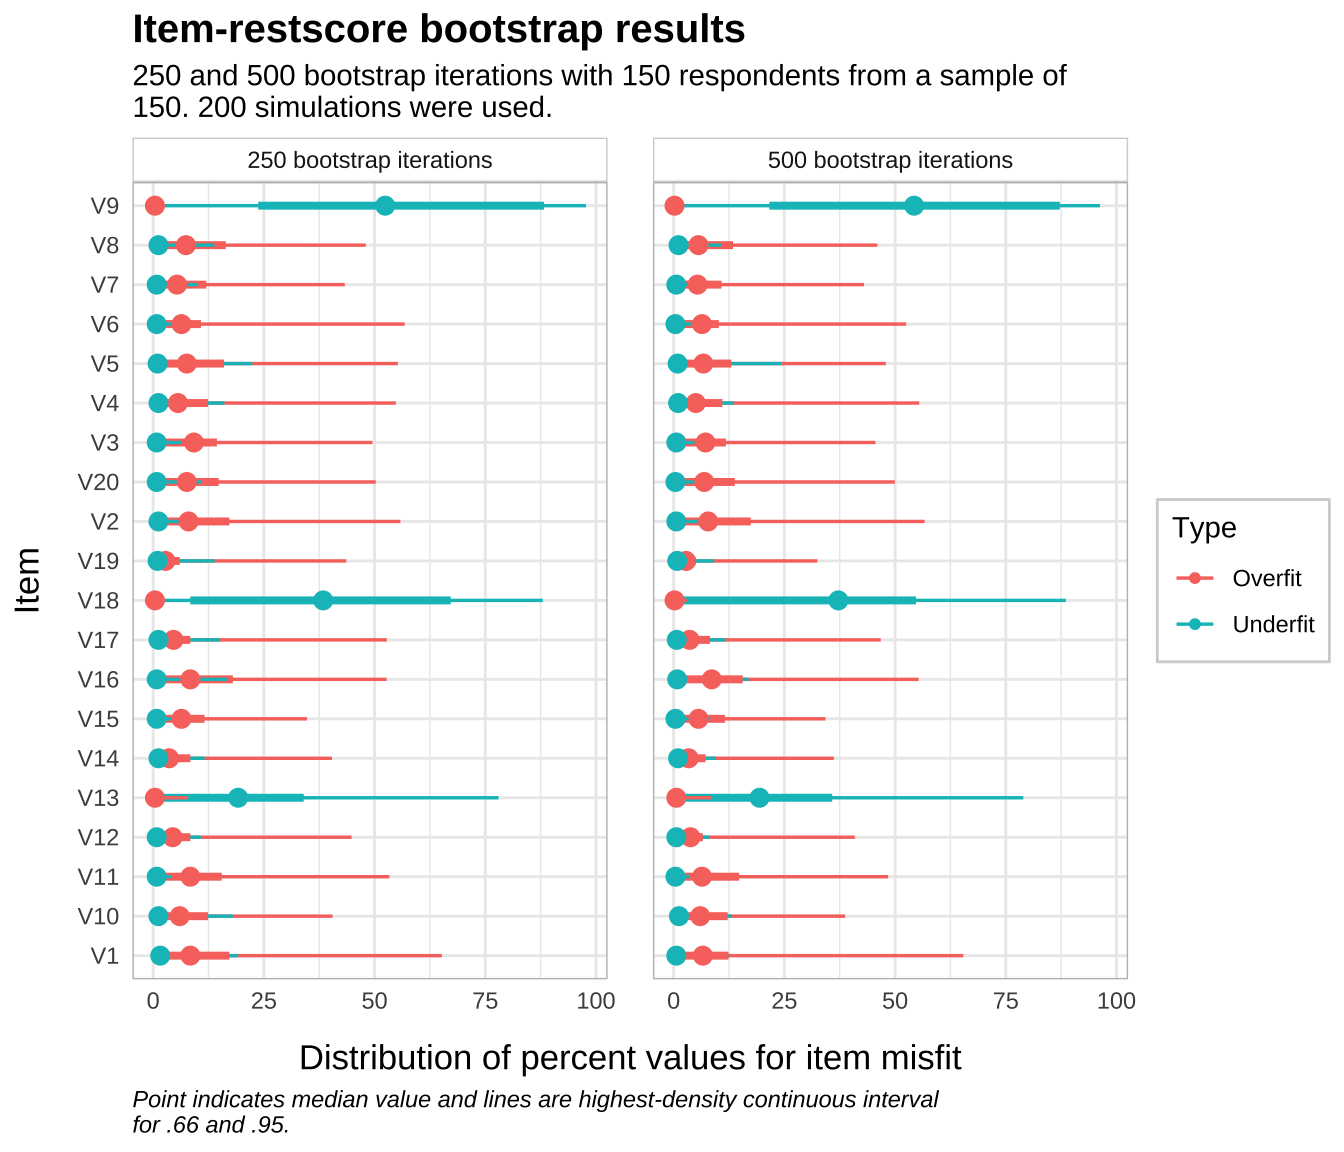

In [ ]:
irb150 <- readRDS("data/irb150.rds")

irb150_df <- bind_rows(irb150)

irb150_df %>% 
  mutate(bootit = factor(bootit, levels = c(250,500),
                         labels = c("250 bootstrap iterations",
                                    "500 bootstrap iterations"))) %>% 
  ggplot(aes(x = percent, y = item, color = item_restscore)) +
  stat_pointinterval(point_interval = "median_hdci") +
  theme_rise(fontfamily = "sans") +
  labs(caption = str_wrap("Point indicates median value and lines are highest-density continuous interval for .66 and .95.",80),
       x = "Distribution of percent values for item misfit", y = "Item",
       title = "Item-restscore bootstrap results",
       subtitle = str_wrap("250 and 500 bootstrap iterations with 150 respondents from a sample of 150. 200 simulations were used.",70)
       ) +
  scale_color_discrete('Type', labels = c("Overfit","Underfit")) +
  facet_wrap(~bootit)

The bootstrapping does not improve on the single instance of item-restscore for the n = 150 condition (see @fig-irboot150). When comparing to the previous results in @fig-itemrestscore2, where the detection rate for the same sample size were at 49.2%, 14.6%, and 34.6% (for items 9, 13, and 18 respectively), the corresponding median values from the bootstrapped item-restscore with 250 iterations were 51.6%, 12.4%, and 37.2%. Using 500 bootstrap iterations did not result in relevant improvements over 250 iterations (see @tbl-irb150mis).

``` r
irb150_df %>% 
  filter(item %in% c("V9","V13","V18"),
         bootit == 250) %>% 
  rename(Item = item) %>% 
  group_by(Item) %>% 
  summarise(Median = median(percent),
            MAD = mad(percent),
            Mean = mean(percent),
            SD = sd(percent),
            p05 = quantile(percent, .05),
            p01 = quantile(percent, .01)
            ) %>% 
  ungroup() %>% 
  arrange(desc(p01)) %>% 
  mutate_if(is.numeric, round, 1) %>% 
  knitr::kable()
irb150_df %>% 
  filter(item %in% c("V9","V13","V18"),
         bootit == 500) %>% 
  rename(Item = item) %>% 
  group_by(Item) %>% 
  summarise(Median = median(percent),
            MAD = mad(percent),
            Mean = mean(percent),
            SD = sd(percent),
            p05 = quantile(percent, .05),
            p01 = quantile(percent, .01)
            ) %>% 
  ungroup() %>% 
  arrange(desc(p01)) %>% 
  mutate_if(is.numeric, round, 1) %>% 
  knitr::kable()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: center;"><div class="cell-output-display" width="100.0%" data-layout-align="center">
<table id="tbl-irb150mis-1" class="do-not-create-environment">
<thead>
<tr>
<th style="text-align: left;">Item</th>
<th style="text-align: right;">Median</th>
<th style="text-align: right;">MAD</th>
<th style="text-align: right;">Mean</th>
<th style="text-align: right;">SD</th>
<th style="text-align: right;">p05</th>
<th style="text-align: right;">p01</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: left;">V13</td>
<td style="text-align: right;">12.4</td>
<td style="text-align: right;">17.8</td>
<td style="text-align: right;">22.5</td>
<td style="text-align: right;">24.7</td>
<td style="text-align: right;">0.4</td>
<td style="text-align: right;">0.4</td>
</tr>
<tr>
<td style="text-align: left;">V18</td>
<td style="text-align: right;">37.2</td>
<td style="text-align: right;">36.2</td>
<td style="text-align: right;">40.4</td>
<td style="text-align: right;">28.4</td>
<td style="text-align: right;">0.9</td>
<td style="text-align: right;">0.4</td>
</tr>
<tr>
<td style="text-align: left;">V9</td>
<td style="text-align: right;">51.6</td>
<td style="text-align: right;">38.0</td>
<td style="text-align: right;">50.4</td>
<td style="text-align: right;">29.8</td>
<td style="text-align: right;">2.9</td>
<td style="text-align: right;">0.4</td>
</tr>
</tbody>
</table>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: center;"><div class="cell-output-display" width="100.0%" data-layout-align="center">
<table id="tbl-irb150mis-2" class="do-not-create-environment">
<thead>
<tr>
<th style="text-align: left;">Item</th>
<th style="text-align: right;">Median</th>
<th style="text-align: right;">MAD</th>
<th style="text-align: right;">Mean</th>
<th style="text-align: right;">SD</th>
<th style="text-align: right;">p05</th>
<th style="text-align: right;">p01</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: left;">V13</td>
<td style="text-align: right;">12.7</td>
<td style="text-align: right;">17.9</td>
<td style="text-align: right;">21.9</td>
<td style="text-align: right;">24.3</td>
<td style="text-align: right;">0.2</td>
<td style="text-align: right;">0.2</td>
</tr>
<tr>
<td style="text-align: left;">V18</td>
<td style="text-align: right;">35.6</td>
<td style="text-align: right;">38.3</td>
<td style="text-align: right;">38.7</td>
<td style="text-align: right;">28.8</td>
<td style="text-align: right;">0.3</td>
<td style="text-align: right;">0.2</td>
</tr>
<tr>
<td style="text-align: left;">V9</td>
<td style="text-align: right;">53.0</td>
<td style="text-align: right;">39.1</td>
<td style="text-align: right;">50.3</td>
<td style="text-align: right;">29.9</td>
<td style="text-align: right;">3.6</td>
<td style="text-align: right;">0.2</td>
</tr>
</tbody>
</table>
</div></td>
</tr>
</tbody>
</table>

Summary statistics for item-restscore bootstrap simulation (n = 150)

# Study 5: Varying number of items

When doing simulation studies there is always a balance to strike between trying to evaluate many scenarios and not having too high complexity. We have been keeping several things constant, such as item locations and number of items, which makes interpretation easier but may limit the applicability of the results. For our final simulation, we will vary the number of items and the number of misfitting items. First, 40 dichotomous items will be used, adding 20 new item locations to the previously used set, with the same three items misfitting (items 9, 13, and 18). Second, items 1-10 out of the initial 20 items will be used, which means only item 9 will be misfit. We’ll again be using sample sizes of 150, 250, 500, and 1000.

Item-restscore and item infit will be compared. The latter will use 100 bootstrap iterations to determine critical values for sample sizes 150 and 250, and 200 bootstrap iterations for n \>= 500.

In [ ]:
itemfitboot3 <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    if (nrow(data < 400)) {
      sfit <- RIgetfit(data,100,9)
    } else if (nrow(data > 400)) {
      sfit <- RIgetfit(data,200,9)
    }
    
    # apply cutoffs and store results
    rfit <- RIitemfit(data, sfit, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 iteration = i,
                 samplesize = samplesize)

    # combine output 
    fit <- rfit
  }
  return(fit)
}

In [ ]:
# simulate data using 40 items
# read pre-generated item locations for reproducibility
items2 <- read_csv("data/rm_items40.csv") %>%
  pull(location)

# a matrix to specify which dimension each item loads on
wmat4 <- matrix(nrow = 40,
               ncol = 2)
# set all items to load on dimension one
wmat4[1:40,1] <- 1
wmat4[1:40,2] <- 0

wmat4[c(9,13,18),1] <- 0
wmat4[c(9,13,18),2] <- 1

# generate dichotomous data
simdata40items <- eRm::sim.xdim(10000, items2, cutpoint = "randomized", Sigma = sigma, weightmat = wmat4)

# check targeting
#RItargeting(as.data.frame(simdata40items), model = "RM")
#RItargeting(simdata3[,1:10], model = "RM")

saveRDS(simdata40items,"data/simdata40items.rds")

In [ ]:
simdata40items <- readRDS("data/simdata40items.rds") %>% 
  as.data.frame()

samplesizes <- c(150,250,500,1000)
ifb10 <- list()
ir10 <- list()

#tic()
ifb40_60 <- map(samplesizes, ~ itemfitboot3(simdata40items, iterations = 60, samplesize = .x))
#toc() # 120s for 2 runs
saveRDS(ifb40_60, "data/ifb40_60i.rds")

ir40 <- map(samplesizes, ~ ir(simdata40items, iterations = 500, samplesize = .x))
saveRDS(ir40, "data/ir40.rds")

ir10 <- map(samplesizes, ~ ir(simdata3[,1:10], iterations = 500, samplesize = .x))
saveRDS(ir10, "data/ir10.rds")

In [ ]:
ir40 <- readRDS("data/ir40.rds")
ir10 <- readRDS("data/ir10.rds")

ifb40_60 <- readRDS("data/ifb40_60i.rds")

ir40_df <- bind_rows(ir40)
ir10_df <- bind_rows(ir10)

ifb40_df <- bind_rows(ifb40_60)

## Results 40 items

(`geom_col()`).

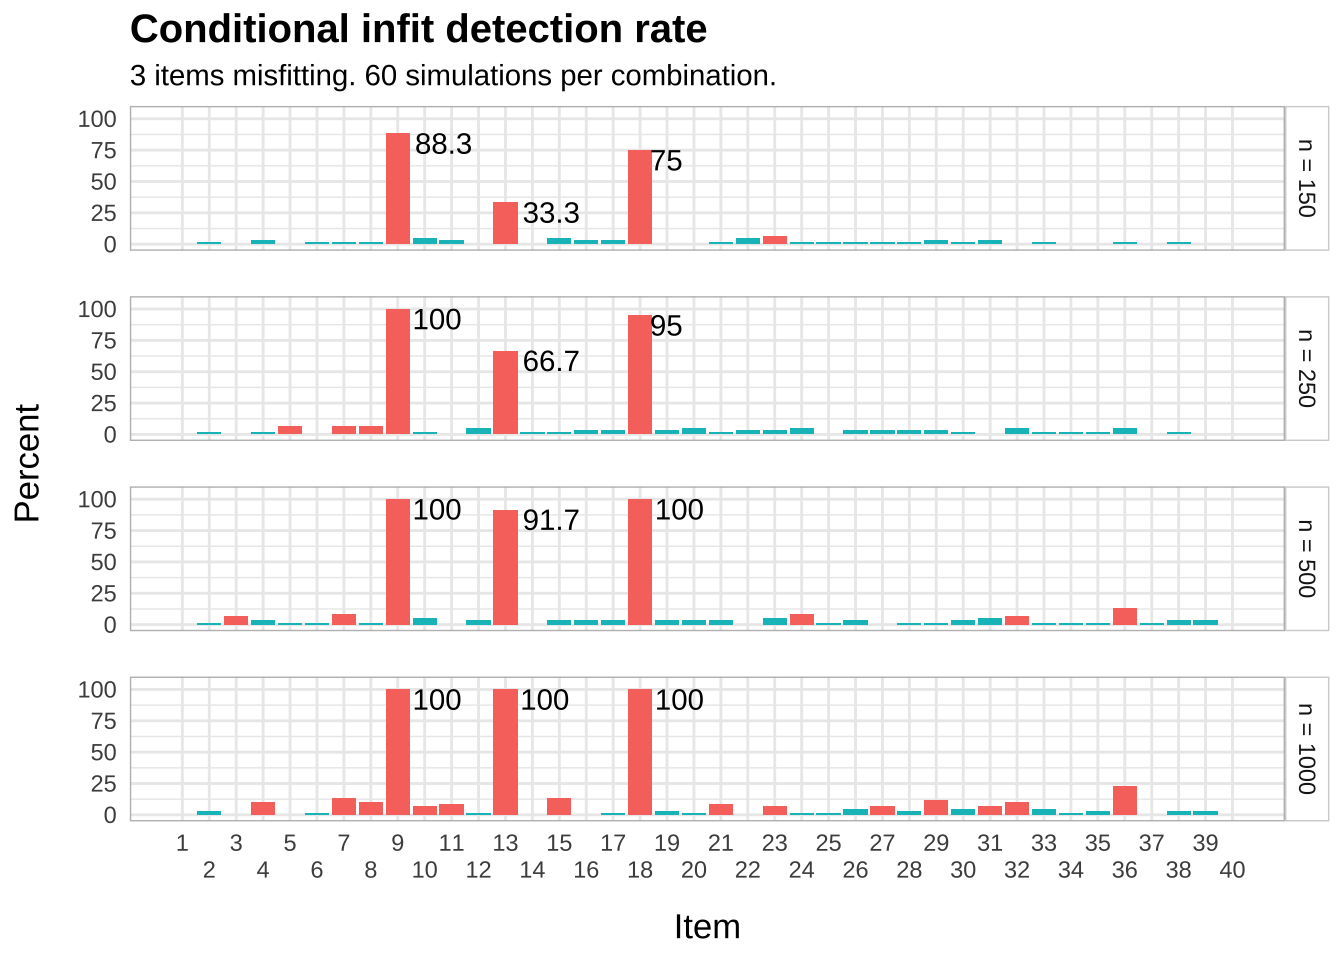

In [ ]:
ifb40_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = round(n/60*100,1)) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000"))) %>% 

  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,40), breaks = seq(1,40,1), guide = guide_axis(n.dodge = 2), minor_breaks = NULL) +
  guides(fill = "none") +
  facet_grid(samplesize~.) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 60 simulations per combination.",
       title = "Conditional infit detection rate")

(`geom_col()`).

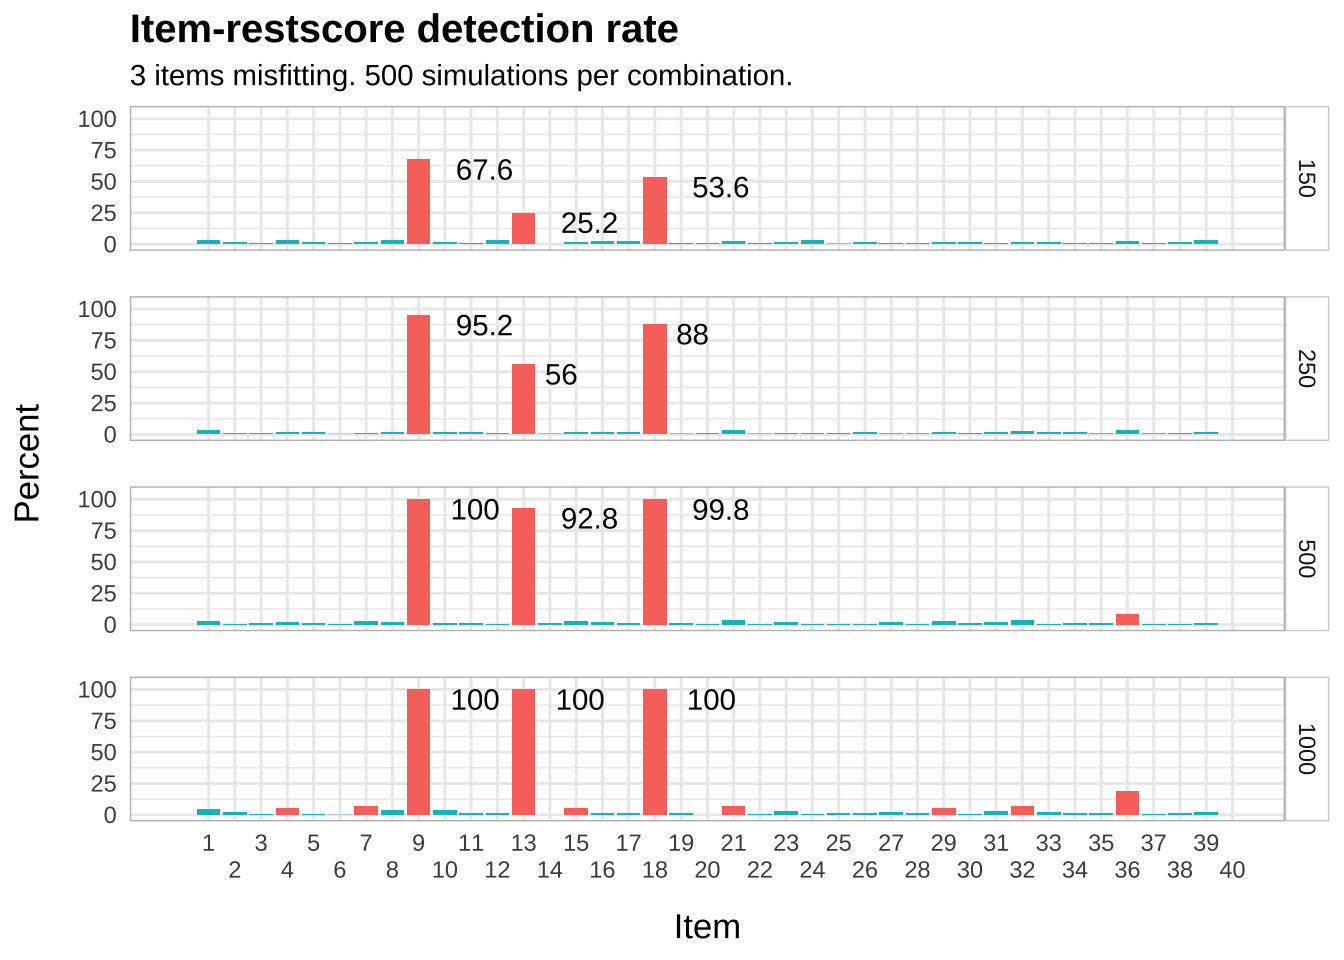

In [ ]:
ir40_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.65, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.65, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.65, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(0,40), 
                     breaks = seq(1,40,1), 
                     guide = guide_axis(n.dodge = 2), minor_breaks = NULL) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 500 simulations per combination.",
       title = "Item-restscore detection rate")

Infit performs better when sample size is 150 or 250 (see @fig-ifb40), while performance is slightly better for item-restscore for n \>= 500 in terms of lower rates of false positives (see @fig-itemrestscore40).

## Results 10 items

(`geom_col()`).

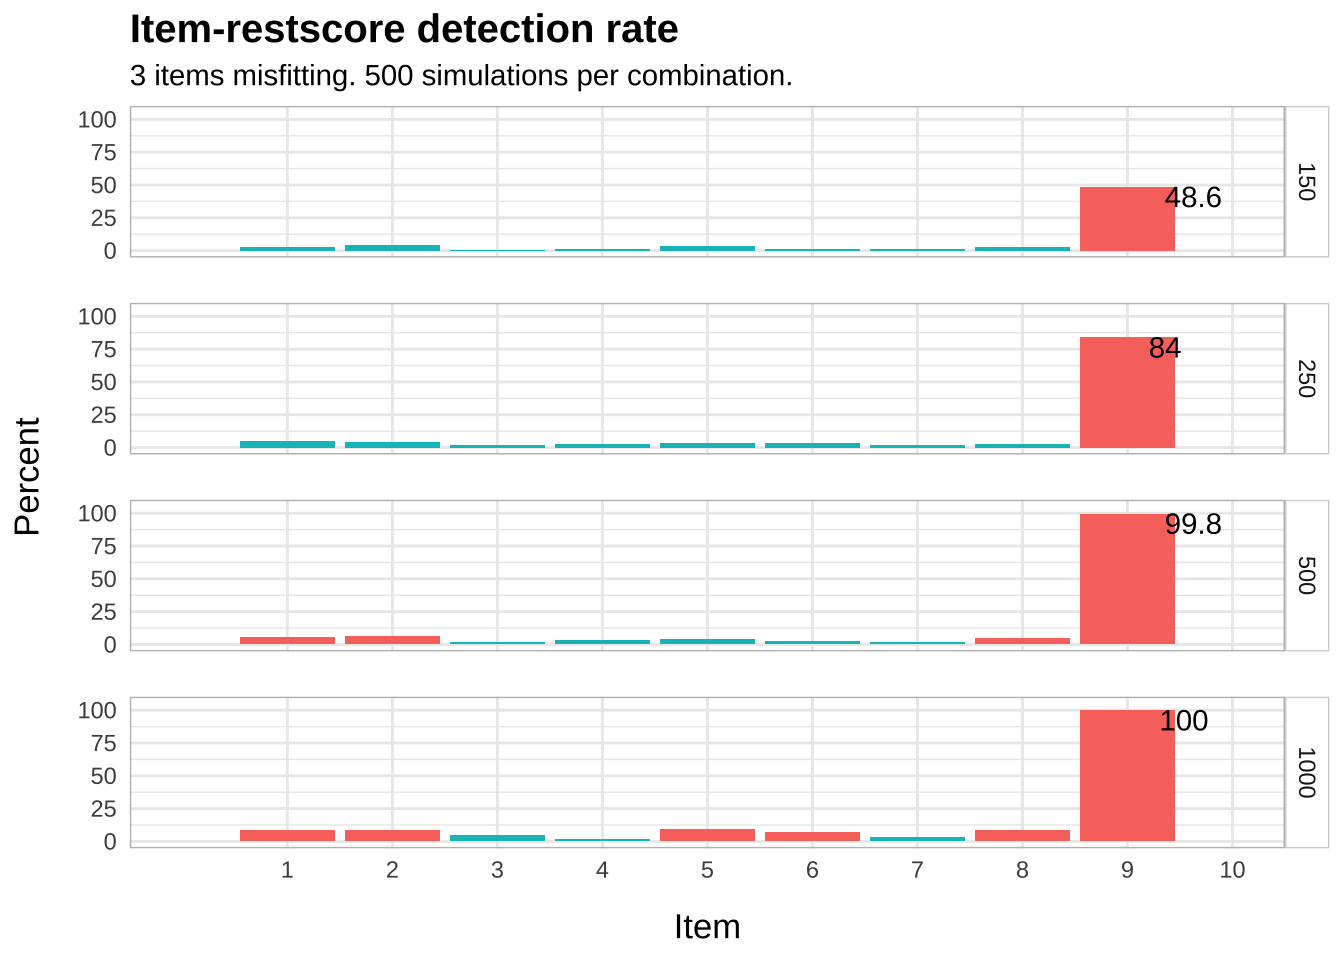

In [ ]:
ir10_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.65, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.65, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.65, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(0,10), 
                     breaks = seq(1,10,1), 
                     guide = guide_axis(n.dodge = 1), minor_breaks = NULL) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 500 simulations per combination.",
       title = "Item-restscore detection rate")

Compared to when we had 20 items, … create a summary table! And run more simulations tonight.

# Discussion

## Limitations

Number of items could be varied more. However, the results from Müller \[-@muller_item_2020\], which use 10, 15, and 20 items, indicates small differences in critical value ranges. But this might not have implications for detection rate of misfitting items (we need the 40 items simulation and maybe 10 also?). Partial credit model for polytomous data would have been nice to also test. Although results regarding detection rate should generalize from RM to PCM, maybe the sample size in relation to number of items does not easily translate from the dichotomous case?

# Conclusion

These findings make a good argument for removing one item at a time when the analysis indicates misfitting items, starting with the most underfitting item. This is especially relevant for *n* \>= 500 and when misfitting items are located close to the sample mean.

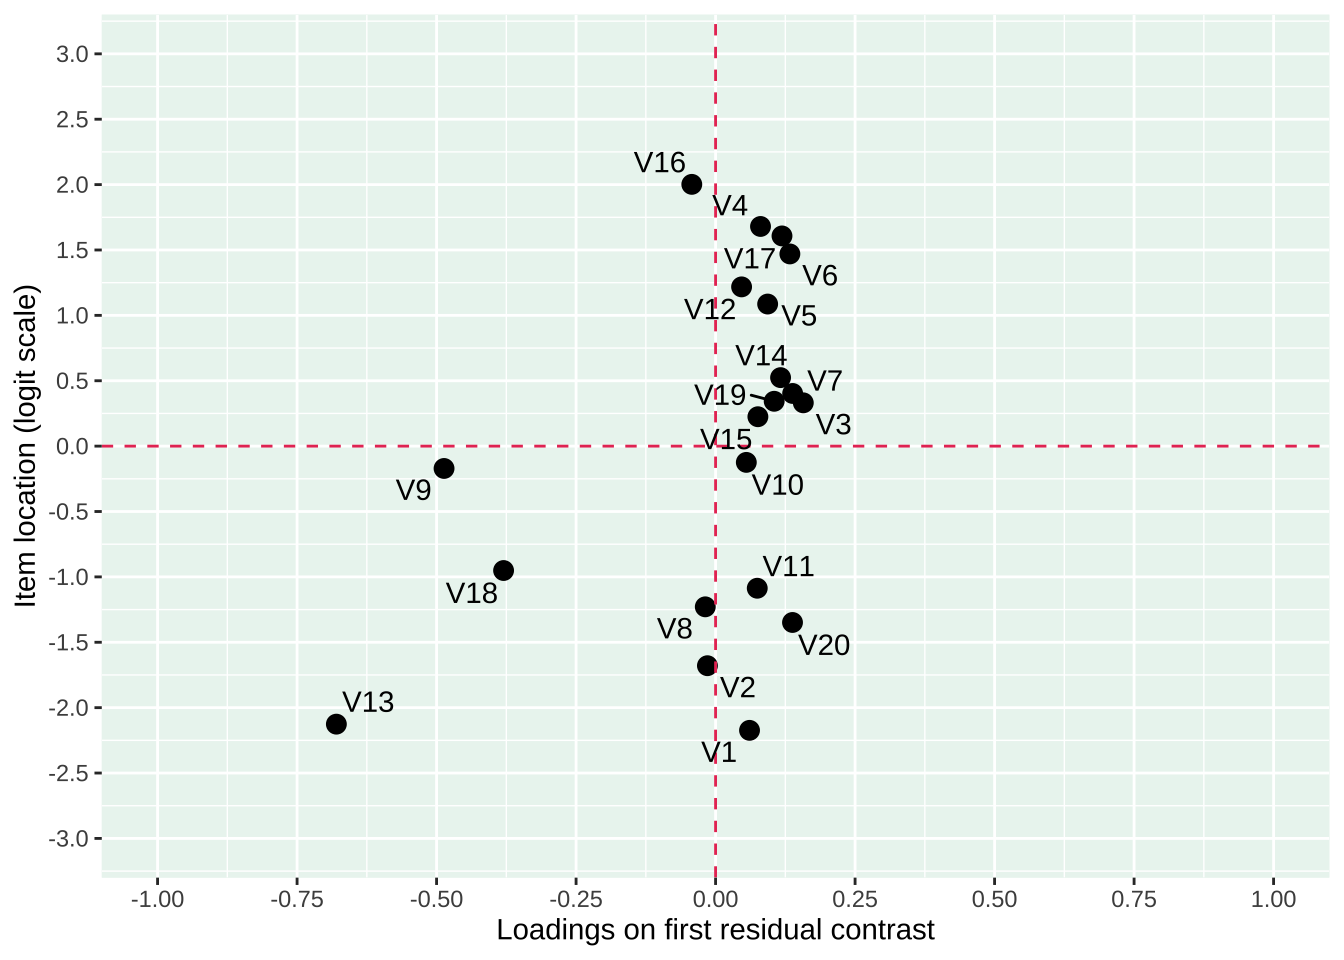

In [ ]:
RIloadLoc(simdata3[1:400,], model = "RM")

Assessing item fit and dimensionality should be done using multiple methods. Item fit and item-restscore should be used in parallel, while also examining residual patterns by reviewing standardized factor loadings on the first residual contrast (see @fig-loadloc for an example) as well as Yen’s Q3 residual correlations.

While the simulations in this paper have used dichotomous data, all functions evaluated in this paper also work with polytomous data using the Rasch Partial Credit Model.

# References

# Additional materials

-   GitHub link for `easyRasch` source code: <https://github.com/pgmj/easyRasch/>
    -   Most functions are defined in this file: <https://github.com/pgmj/easyRasch/blob/main/R/easyRasch.R>

## Session info

This documents the specific R packages and versions used in this study.

In [ ]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: aarch64-apple-darwin20
Running under: macOS Sequoia 15.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] sv_SE.UTF-8/sv_SE.UTF-8/sv_SE.UTF-8/C/sv_SE.UTF-8/sv_SE.UTF-8

time zone: Europe/Stockholm
tzcode source: internal

attached base packages:
 [1] parallel  grid      stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] showtext_0.9-7    showtextdb_3.0    sysfonts_0.8.9    arrow_16.1.0     
 [5] easyRasch_0.3.3   doParallel_1.0.17 iterators_1.0.14  furrr_0.3.1      
 [9] future_1.34.0     foreach_1.5.2     janitor_2.2.0     hexbin_1.28.4    
[13] catR_3.17         glue_1.8.0        ggrepel_0.9.6     patchwork_1.3.0  
[17] reshape_0.8.9     matrixStats_1.4.1 psychotree_0.16-1 psychotools_0.7-4